In [ ]:
import xarray as xr

ds = xr.open_dataset(r"E:\2022\pansharpened_202211031357574.nc")
ds


In [ ]:
import numpy as np

ds = xr.open_dataset(r"E:\2022\pansharpened_202211031357574.nc", chunks={"x": 2000, "y": 2000})

# Regrid the data to a new grid
new_x = np.linspace(ds.x.min(), ds.x.max(), 2000)
new_y = np.linspace(ds.y.min(), ds.y.max(), 2000)

ds_g = ds.interp(
   x=new_x, 
   y=new_y, 
   method="linear"
)

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    ds_g = ds_g.compute()
ds_g

In [ ]:
import run_model
import build_dataset
import utils
import xarray as xr

files = [r"D:\Maestría\Tesis\Repo\data\data_in\Compressed\2013\pansharpened_6741392101_R2C1.tif", r"D:\Maestría\Tesis\Repo\data\data_in\Compressed\2013\pansharpened_6741392101_R2C2.tif"]
datasets = {
        f.split("\\")[-1].replace(".tif", ""): (xr.open_dataset(f))
        for f in files
}
extents = {name: utils.get_dataset_extent(ds) for name, ds in datasets.items()}

In [ ]:
import utils
import build_dataset

def add_datasets_combinations(datasets):
    from shapely.geometry import box

    extents = {name: utils.get_dataset_extent(ds) for name, ds in datasets.items()}
    combinations = {}
    to_remove = []

    for ds_name, ds in datasets.items():
        # Construyo lista de datasets que intersectan con ds_name
        capture_ds_name = ds_name.split("_")[1]
        ds_extent = extents[ds_name]
        buffered_extent = ds_extent.buffer(0.04).envelope
        xmin, ymin, xmax, ymax = buffered_extent.bounds

        intersecting = []
        for name, ds_extent in extents.items():
            capture_name = name.split("_")[1]
            if (
                ds_extent.intersects(buffered_extent)
                & (name != ds_name)
                & (capture_ds_name == capture_name)
            ):
                intersecting += [name]

        # Recorto datasets de intersection (buffer de 1080px):
        cropped_datasets = {}
        for intersection in intersecting:
            intersecting_ds = datasets[intersection]
            cropped_datasets[intersection] = intersecting_ds.sel(
                x=slice(xmin, xmax), y=slice(ymax, ymin)
            )

        # Armo xarray con la intersección de a pares
        for cropped_name, cropped_ds in cropped_datasets.items():

            names = [ds_name, cropped_name]
            names = [name.replace("pansharpened_", "") for name in names]
            names.sort()
            combined_name = "comb_" + "_".join(names)

            if combined_name not in combinations:
                polygon = box(
                    cropped_ds.x.min(),
                    cropped_ds.y.min(),
                    cropped_ds.x.max(),
                    cropped_ds.y.max(),
                )
                buffered_extent = polygon.buffer(0.005).envelope
                xmin, ymin, xmax, ymax = buffered_extent.bounds

                cropped_main_ds = ds.sel(x=slice(xmin, xmax), y=slice(ymax, ymin))
                cropped_ds = remove_overlapping_pixels(cropped_main_ds, cropped_ds)

                # print(ds_name, cropped_name)
                # print(cropped_main_ds)
                # print(cropped_ds)

                try:
                    result_ds = xr.combine_by_coords(
                        [cropped_main_ds, cropped_ds], combine_attrs="override"
                    )

                    # Store xarray and reload to remove cross-references across objects and reduce memory usage
                    filename = rf"{path_dataout}/tempfiles/{combined_name}.pkl"
                    pickle_xr_dataset(ds, filename)
                    with open(filename, "rb") as f:
                        result_ds = pickle.load(f)
                    to_remove += [filename]

                    combinations[combined_name] = result_ds
                except Exception as e:
                    print(e)

    all_datasets = combinations | datasets

    return all_datasets


In [ ]:
import run_model
all_years_datasets, all_years_extents, df = run_model.open_datasets(
    sat_data="pleiades", years=[2022]
)


In [ ]:
import warnings
import dask
import xarray as xr
warnings.simplefilter("ignore") 

datasets = {}
for year in [2022]:
    path = rf"\\wsl.localhost\UbuntuE\home\nico\data\{year}"
    files = os.listdir(path)
    files = [f for f in files if f.endswith(".tif")]
    capture_ids = set([f.split("_")[1] for f in files])

    files_by_id = {}
    for capture_id in capture_ids:
        # Split files by capture_id
        files = [
            rf"{path}/{f}" for f in files if capture_id in f
        ]

        print(f"Loading capture {capture_id} - {year}")
        try:
            files.sort()
            files_matrix = generate_matrix_of_files(files)
            with dask.config.set(**{'array.slicing.split_large_chunks': True}):
                ds = xr.open_mfdataset(
                        files_matrix, 
                        combine="nested", 
                        concat_dim=["x", "y"], 
                        engine="rasterio",
                        chunks={"x": 500, "y": 500}
                )
                # ds = ds.chunk()            
                datasets[capture_id] = ds
                
        except Exception as e:
            print(f"Error loading {capture_id}")
            print(e)
            
        break


In [ ]:
import numpy as np
import earthpy.plot as ep
# Select random point from the dataset

# dataset = datasets["202212041353517"]
# point = (np.random.choice(dataset.x), np.random.choice(dataset.y))
# img_size = 128

def image_from_point(dataset, point, img_size=128):

    # Find the rearest raster of this random point
    x, y = point
    idx_x = np.searchsorted(dataset.x, x, side="left", sorter=None)
    idx_y = np.searchsorted(
        -dataset.y, -y, side="left", sorter=None
    )  # The y array is inverted! https://stackoverflow.com/questions/43095739/numpy-searchsorted-descending-order

    # Create the indexes of the box of the image
    idx_x_min = round(idx_x - img_size / 2)
    idx_x_max = round(idx_x + img_size / 2)
    idx_y_min = round(idx_y - img_size / 2)
    idx_y_max = round(idx_y + img_size / 2)

    # If any of the indexes are negative, move to the next iteration
    if (
        (idx_x_min < 0)
        | (idx_x_max > dataset.x.size)
        | (idx_y_min < 0)
        | (idx_y_max > dataset.y.size)
    ):
        image = np.zeros(shape=(1, 1, 1))
        return image

    image = dataset.isel(x=slice(idx_x_min, idx_x_max), y=slice(idx_y_min, idx_y_max))

    image = image.band_data

    if image.chunks is not None:
        # If the image is not computed, compute it
        image = image.compute()

    return image

# img_size = 128
# point = (np.random.choice(dataset.x), np.random.choice(dataset.y))

# image = image_from_point(dataset, point, img_size=512)
# if image.max() != 0:  
#     image = image.values  
#     ep.plot_rgb(image, rgb=[0, 1, 2], title="RGB Image")


# image = dataset.isel(x=slice(100, 1000), y=slice(100, 1000))


In [ ]:
import os
import xarray as xr

path_satelites = r"\\wsl.localhost\UbuntuE\home\nico\data"

def generate_matrix_of_files(files):
    """Create a matrix of files to be loaded by xr.open_mfdataset.

    Files are ordered as the original tiles, where R1C3 is the first tile of the third column.
    Run xr.open_mfdataset(matrix, combine="nested", concat_dim=["x", "y"], engine="rasterio") after this.

    Parameters:
    files (list): List of files to be loaded

    Returns:
    matrix (list): List of lists of files to be loaded by xr.open_mfdataset
    """
    files.sort()

    matrix = []
    for col in range(1, 5):
        cols_files = [f for f in files if f"C{col}.tif" in f]
        if len(cols_files) > 0:
            matrix += [cols_files]
    return matrix


def load_satellite_datasets(year=2013, stretch=False):
    """Load satellite datasets and get their extents"""
    print(rf"{path_satelites}\{year}")
    import warnings

    warnings.simplefilter("ignore")

    if not os.path.isdir(rf"{path_satelites}\{year}"):
        raise ValueError(f"Year {year} images not found. Check they are stored in WSL!")

    files = os.listdir(rf"{path_satelites}\{year}")
    files = [f for f in files if f.endswith(".tif")]
    capture_ids = set([f.split("_")[1] for f in files])

    assert all([os.path.isfile(rf"{path_satelites}\{year}\{f}") for f in files])

    files_by_id = {}
    datasets = {}
    for capture_id in capture_ids:
        # for capture_id, files in files_by_id.items():
        id_files = [rf"{path_satelites}\{year}\{f}" for f in files if capture_id in f]
        id_files_matrix = generate_matrix_of_files(id_files)

        ds = xr.open_mfdataset(
            id_files_matrix,
            combine="nested",
            concat_dim=["y", "x"],
            engine="rasterio",
            chunks={"x": 200, "y": 200},
        )
        datasets[capture_id] = ds
    # extents = {name: utils.get_dataset_extent(ds, 512) for name, ds in datasets.items()}

    return datasets


In [ ]:
import utils 

stacked_images = [1,4]
n_bands = 4
size = 128
resizing_size = 128

def get_grid_data(point, ds):
    # Decoding from the EagerTensor object. Extracts the number/value from the tensor
    #   example: <tf.Tensor: shape=(), dtype=uint32, numpy=20> -> 20
    # initialize iterators & params
    image = np.zeros(shape=(n_bands, 0, 0))
    total_bands = n_bands * len(stacked_images)
    img_correct_shape = (total_bands, size, size)

    # Get link, dataset and indicator value of the corresponding index
    id_point, raster_point = "123", point

    # Get data for selected point
    raster_point = point
    
    # Generate the image
    image, _ = utils.stacked_image_from_census_tract(
        dataset=ds,
        polygon=None,
        point=raster_point,
        img_size=size,
        n_bands=n_bands,
        stacked_images=stacked_images,
    )
    
    if image.shape != img_correct_shape:
        print(
            f"Could not retrieve a valid image for point {raster_point} (id: {id_point}), moving to next image..."
        )
        image = np.zeros(shape=(resizing_size, resizing_size, total_bands))
        return image
    else:
        return image

In [126]:
import importlib
import utils
import build_dataset
importlib.reload(utils)
importlib.reload(build_dataset)


<module 'build_dataset' from 'd:\\Maestría\\Tesis\\Repo\\scripts\\build_dataset.py'>

In [129]:
import geopandas as gpd
grid = gpd.read_parquet(r"D:\Maestría\Tesis\Repo\data\data_out\grid_datasets\grid_2018_proc.parquet")

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\frame.py:717: DeprecationWarning: Passing a BlockManager to DataFrame is deprecated and will raise in a future version. Use public APIs instead.
  warnings.warn(


Reading dataset...
\\wsl.localhost\UbuntuE\home\nico\data/2013
Links without images (2013): 2890 out of 14400
Remaining links for train/test (2013): 11510
\\wsl.localhost\UbuntuE\home\nico\data/2018
Links without images (2018): 3041 out of 14551
Remaining links for train/test (2018): 11510
\\wsl.localhost\UbuntuE\home\nico\data/2022
Links without images (2022): 4032 out of 15542
Remaining links for train/test (2022): 11510
Datasets loaded!


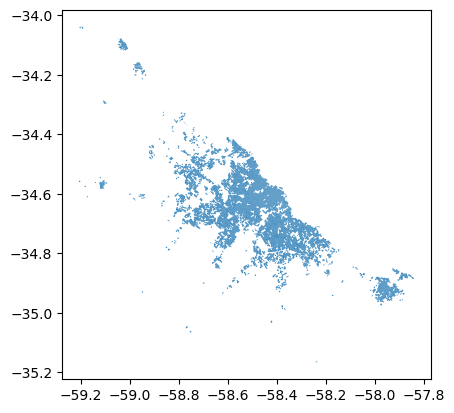

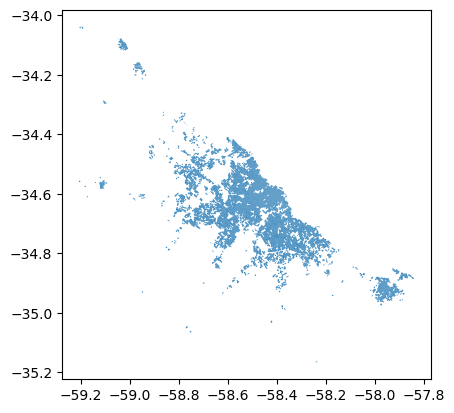

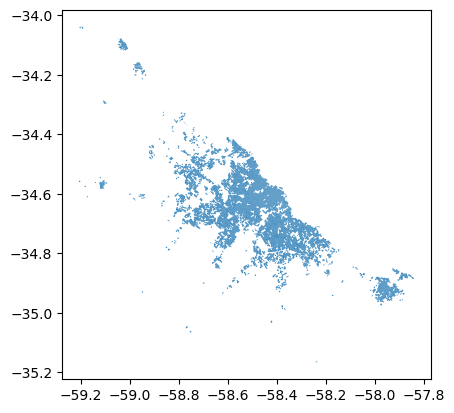

In [128]:
import run_model
datasets_all_years, extents_all_years, df = run_model.open_datasets(sat_data="pleiades", years=[2013, 2018, 2022])
year_datasets, extents = datasets_all_years[2018], extents_all_years[2018]

In [292]:
grid["n_datasets"] = grid["dataset_2018"].apply(lambda x: len(x))
grid[grid["n_datasets"]==4].sample().id

447942    1074698
Name: id, dtype: int64

In [304]:
from IPython.display import clear_output
import earthpy.plot as ep
import numpy as np

importlib.reload(utils)
importlib.reload(build_dataset)

while True:
    clear_output(wait=True)
    id_point = grid[grid["n_datasets"]>1].sample().id.squeeze()
    # id_point=1229375
    # print(id_point)
    n_bands = 4
    stacked_images = [1, 4]
    year = 2022
    size = 128

    image = np.zeros(shape=(n_bands, 0, 0))
    total_bands = n_bands * len(stacked_images)

    # Get link, dataset and indicator value of the corresponding index
    raster_point = grid[grid["id"] == id_point].point.squeeze()

    # Get data for selected point
    raster_point = (raster_point.x, raster_point.y)

    cell_datasets = build_dataset.get_dataset_for_gdf(
        grid, year_datasets, id_point, year=2018, id_var="id"
    )

    image, _ = utils.stacked_image_from_census_tract(
        dataset=cell_datasets,
        polygon=None,
        point=raster_point,
        img_size=size,
        n_bands=n_bands,
        stacked_images=stacked_images,
    )
   
    if image.shape != (total_bands, size, size):
        if len(cell_datasets) == 1:
            continue
        
    ep.plot_rgb(image, rgb=[4, 5, 6], title="RGB Image")

\\wsl.localhost\UbuntuE\home\nico\data\2018\pansharpened_6742955101_R2C1.tif
6897 30297
(4, 128, 128)
\\wsl.localhost\UbuntuE\home\nico\data\2018\pansharpened_6742955101_R3C1.tif
6897 0
(4, 64, 128)


IndexError: index 4 is out of bounds for axis 0 with size 4

In [296]:
raster_point[1], raster_point[0]

(-34.59559647700001, -58.564428939)

In [299]:
len(cell_datasets)

3

In [306]:
importlib.reload(utils)
image_ds = utils.dataset_for_image_at_bound(cell_datasets, raster_point, 512)
image_ds

\\wsl.localhost\UbuntuE\home\nico\data\2018\pansharpened_6742955101_R2C1.tif
6897 30297
(4, 512, 512)
\\wsl.localhost\UbuntuE\home\nico\data\2018\pansharpened_6742955101_R3C1.tif
6897 0
(4, 256, 512)


<xarray.Dataset> Size: 6MB
Dimensions:      (band: 4, y: 768, x: 512)
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 4kB -58.34 -58.34 -58.34 ... -58.33 -58.33 -58.33
  * y            (y) float64 6kB -34.84 -34.84 -34.84 ... -34.85 -34.85 -34.85
    spatial_ref  int32 4B 0
Data variables:
    band_data    (band, y, x) float32 6MB 53.0 48.0 44.0 ... 116.0 118.0 121.0

In [302]:
image_ds

In [221]:
cell_datasets[0].isel(y=slice(30700, 30800))

<xarray.Dataset> Size: 5MB
Dimensions:      (band: 4, x: 15678, y: 20)
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 125kB -58.42 -58.42 -58.42 ... -58.35 -58.35 -58.35
  * y            (y) float64 160B -34.6 -34.6 -34.6 -34.6 ... -34.6 -34.6 -34.6
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 5MB ...

In [193]:
image_ds

In [154]:
cell_datasets[1]

<xarray.Dataset> Size: 8GB
Dimensions:      (band: 4, x: 15678, y: 30720)
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 125kB -58.42 -58.42 -58.42 ... -58.35 -58.35 -58.35
  * y            (y) float64 246kB -34.6 -34.6 -34.6 ... -34.74 -34.74 -34.74
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 8GB ...

In [143]:
1237146

2

In [150]:
grid[grid["id"] == 1229375].geometry.explore()

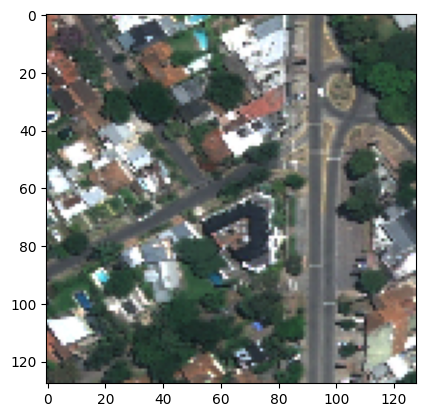

In [107]:
import matplotlib.pyplot as plt

resizing_size=128
n_bands=4
stacked_images = [1,4]
datasets = year_datasets

def get_grid_data(i):
    # Decoding from the EagerTensor object. Extracts the number/value from the tensor
    #   example: <tf.Tensor: shape=(), dtype=uint32, numpy=20> -> 20
    # i = i.numpy()
    # initialize iterators & params
    image = np.zeros(shape=(n_bands, 0, 0))
    total_bands = n_bands * len(stacked_images)
    img_correct_shape = (total_bands, size, size)

    # Get link, dataset and indicator value of the corresponding index
    id_point, raster_point = grid.loc[grid.id == i, ["id", "point"]].values.squeeze()
    raster_point = (raster_point.x, raster_point.y)
    cell_datasets = build_dataset.get_dataset_for_gdf(
        grid, datasets, id_point, year=year, id_var="id"
    )
    if len(cell_datasets) == 0:
        print(
            f"No datasets for point {raster_point} (id: {id_point}), moving to next image..."
        )
        image = np.zeros(shape=(resizing_size, resizing_size, total_bands))
        return image

    # Generate the image
    image = utils.stacked_image_from_census_tract(
        dataset=cell_datasets,
        polygon=None,
        point=raster_point,
        img_size=size,
        n_bands=n_bands,
        stacked_images=stacked_images,
        bounds=False,
    )
    if image.shape != img_correct_shape:
        print(
            f"Could not retrieve a valid image for point {raster_point} (id: {id_point}) in link {link_name}, moving to next image..."
        )
        image = np.zeros(shape=(resizing_size, resizing_size, total_bands))
        return image

    # Reduce quality and process image
    image = utils.process_image(image, resizing_size=resizing_size)
    # np.save(fr"/mnt/d/Maestría/Tesis/Repo/data/data_out/grid_datasets/img_{i}_{id_point}.npy", image)
    # print(f"Se creó /mnt/d/Maestría/Tesis/Repo/data/data_out/grid_datasets/img_{i}_{id_point}.npy")
    return image

image = get_grid_data(767465)
plt.imshow(image[:,:,4:7])#.plot_rgb(image, rgb=[4, 5, 6], title="RGB Image")

NameError: name 'link_name' is not defined

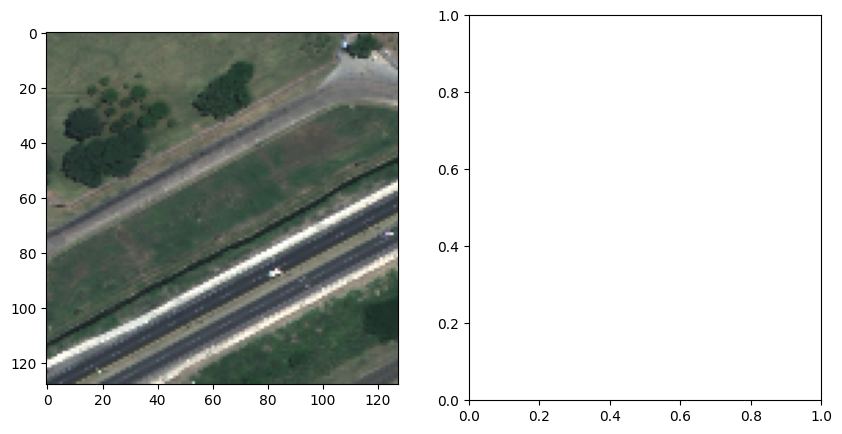

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

image = get_grid_data(766599)
axs[0].imshow(image[:,:,4:7])#.plot_rgb(image, rgb=[4, 5, 6], title="RGB Image")

image = get_grid_data(736939)
axs[1].imshow(image[:,:,4:7])#.plot_rgb(image, rgb=[4, 5, 6], title="RGB Image")


In [85]:
image.shape

(128, 128, 8)

In [78]:
a, b = grid.loc[grid.id == 769212, ["id", "point"]].values.squeeze()
a

769212

In [65]:
get_grid_data(5000)

array([[[ 82,  77,  78, ...,  57,  48, 204],
        [ 92,  85,  83, ...,  51,  46, 159],
        [ 90,  85,  83, ...,  62,  52, 166],
        ...,
        [ 95,  87,  82, ...,  75,  67, 134],
        [ 94,  86,  81, ...,  71,  61, 128],
        [ 92,  84,  79, ...,  75,  67, 136]],

       [[ 84,  78,  79, ...,  64,  57, 189],
        [ 85,  81,  79, ...,  42,  37, 101],
        [ 85,  81,  79, ...,  59,  54, 138],
        ...,
        [ 91,  84,  83, ...,  83,  73, 155],
        [ 89,  82,  81, ...,  79,  69, 141],
        [ 86,  79,  79, ...,  87,  78, 154]],

       [[ 88,  81,  78, ...,  73,  65, 163],
        [ 85,  82,  81, ...,  77,  68, 173],
        [ 87,  82,  80, ...,  45,  42,  95],
        ...,
        [ 89,  81,  82, ...,  79,  69, 129],
        [ 88,  80,  80, ...,  96,  82, 163],
        [ 85,  78,  78, ..., 120, 100, 184]],

       ...,

       [[ 42,  60,  50, ...,  51,  48, 148],
        [ 44,  60,  49, ...,  63,  56, 168],
        [ 45,  62,  50, ...,  50,  42, 140

In [16]:
len(cell_datasets)

2

In [6]:
cell_datasets

[<xarray.Dataset> Size: 15GB
 Dimensions:      (band: 4, x: 30720, y: 30720)
 Coordinates:
   * band         (band) int32 16B 1 2 3 4
   * x            (x) float64 246kB -58.55 -58.55 -58.55 ... -58.47 -58.47 -58.47
   * y            (y) float64 246kB -34.58 -34.58 -34.58 ... -34.66 -34.66 -34.66
     spatial_ref  int32 4B ...
 Data variables:
     band_data    (band, y, x) float32 15GB ...,
 <xarray.Dataset> Size: 15GB
 Dimensions:      (band: 4, x: 30720, y: 30720)
 Coordinates:
   * band         (band) int32 16B 1 2 3 4
   * x            (x) float64 246kB -58.47 -58.47 -58.47 ... -58.39 -58.39 -58.39
   * y            (y) float64 246kB -34.58 -34.58 -34.58 ... -34.66 -34.66 -34.66
     spatial_ref  int32 4B ...
 Data variables:
     band_data    (band, y, x) float32 15GB ...]

In [33]:
# PRINT ds names:
[ds.encoding["source"] for ds in cell_datasets]

['\\\\wsl.localhost\\UbuntuE\\home\\nico\\data\\2022\\pansharpened_202211031357171_R5C1.tif',
 '\\\\wsl.localhost\\UbuntuE\\home\\nico\\data\\2022\\pansharpened_202211031357171_R5C2.tif']

In [43]:
dss = [
    cell_datasets[0].isel(y=slice(4000, 5000), x=slice(-1000, None)),
    cell_datasets[1].isel(y=slice(4000, 5000), x=slice(0, 1000))
]

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\earthpy\spatial.py:561: RuntimeWarning: invalid value encountered in cast
  return (bytedata.clip(low, high) + 0.5).astype("uint8")


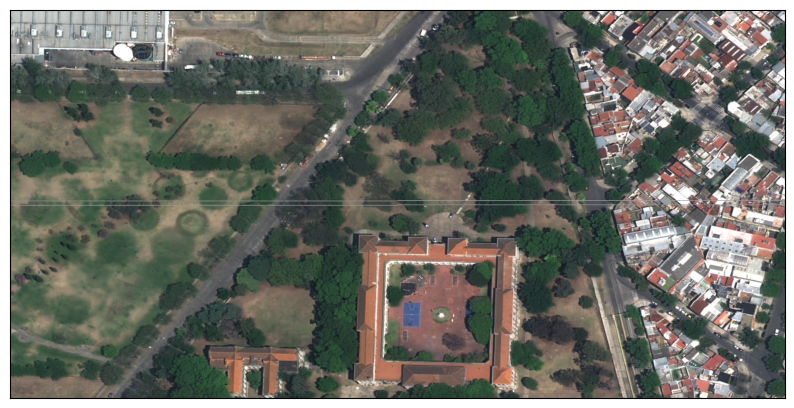

<Axes: >

In [44]:
import xarray as xr
ep.plot_rgb(xr.combine_by_coords(dss).band_data.values)

In [2]:
import xarray as xr
test = xr.open_dataset(r"D:\Maestría\Tesis\Repo\data\data_in\Compressed\2022\pansharpened_000047717_1_26_F_6_R5C2.tif")
test

c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)
c:\Users\ofici\AppData\Local\Programs\Python\Python311\Lib\site-packages\xarray\backends\plugins.py:159: RuntimeWarning: 'ee' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.Dataset> Size: 15GB
Dimensions:      (band: 4, x: 30720, y: 30720)
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 246kB -58.47 -58.47 -58.47 ... -58.39 -58.39 -58.39
  * y            (y) float64 246kB -34.58 -34.58 -34.58 ... -34.66 -34.66 -34.66
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 15GB ...

In [35]:
image_size = 128
images_to_stack = []
total_bands = n_bands * len(stacked_images)

for size_multiplier in stacked_images:
    image_size = size * size_multiplier
    if type(cell_datasets) == list:
        if len(cell_datasets) > 1:
            image_ds = utils.dataset_for_image_at_bound(cell_datasets, raster_point, image_size)
        else:
            image_ds = cell_datasets[0]
    else:
        image_ds = cell_datasets

    image_da = utils.image_from_point(image_ds, raster_point, image_size)
    # try:
    #     image = image_da.to_numpy()[:n_bands, ::size_multiplier, ::size_multiplier]
    #     # print(image)
    #     image = np.nan_to_num(image)
    #     image = image.astype(np.uint8)
    #     images_to_stack += [image]
    # except Exception as e:
    #     print(e)
    #     # image = np.zeros(shape=(n_bands, 1, 1))
    #     # bounds = None
    stop

# Get total bounds
bounds = utils.get_image_bounds(image_da)  # The last image has to be the bigger
image = np.concatenate(images_to_stack, axis=0)  # Concat over bands
assert image.shape == (total_bands, size, size)


NameError: name 'stop' is not defined

In [41]:
cell_datasets[0].x

<xarray.DataArray 'x' (x: 30720)> Size: 246kB
array([-58.669966, -58.669964, -58.669961, ..., -58.587032, -58.587029,
       -58.587026])
Coordinates:
  * x            (x) float64 246kB -58.67 -58.67 -58.67 ... -58.59 -58.59 -58.59
    spatial_ref  int32 4B ...

In [37]:
raster_point

(-58.671808938999995, -34.554296476999994)

In [36]:
image_da

<xarray.DataArray 'band_data' (band: 4, y: 128, x: 0)> Size: 0B
[0 values with dtype=float32]
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 0B 
  * y            (y) float64 1kB -34.55 -34.55 -34.55 ... -34.55 -34.55 -34.55
    spatial_ref  int32 4B ...
Attributes:
    AREA_OR_POINT:  Area

In [20]:
grid[grid["id"] == id_point]["geometry"].explore()

In [11]:
image

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])

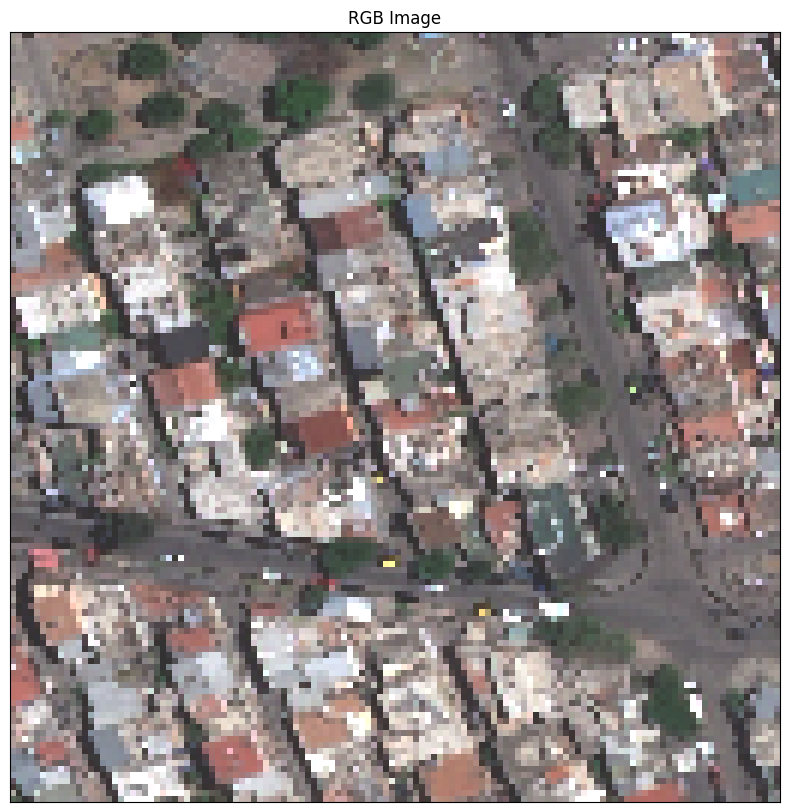

667701
else
else


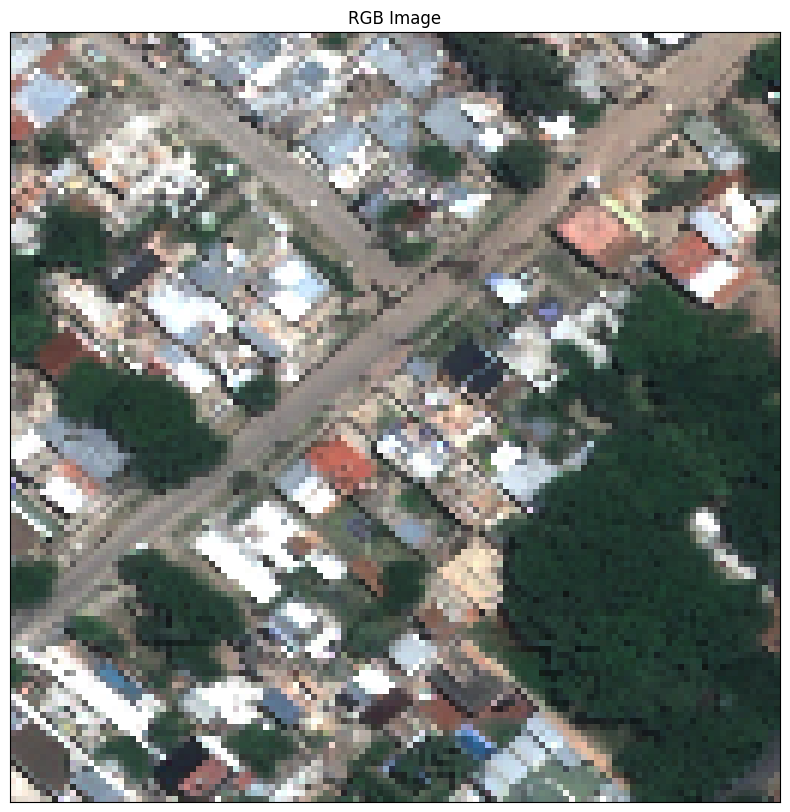

1337596
else
else


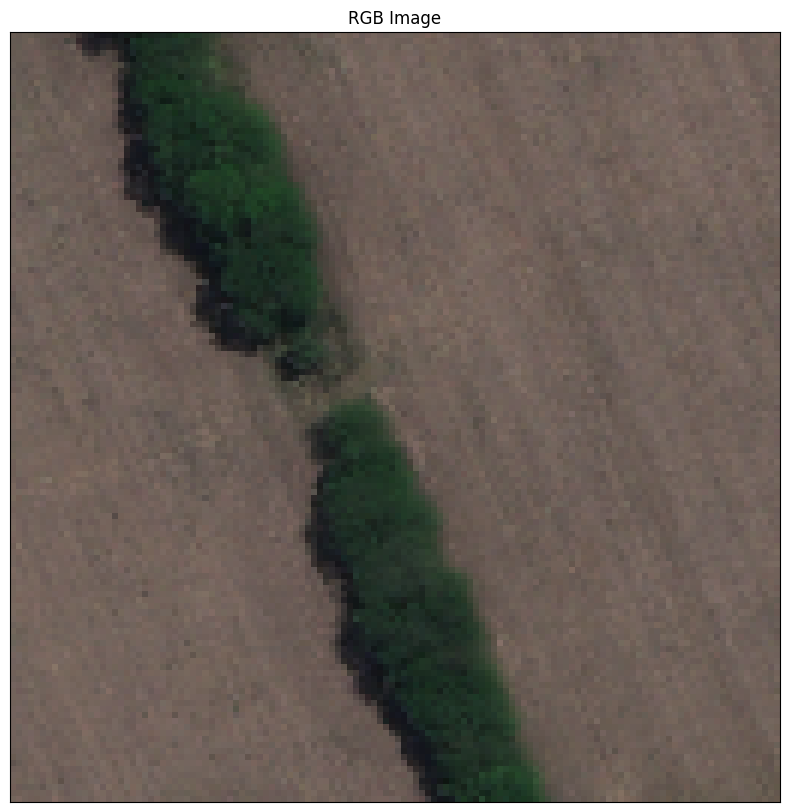

795741
else
else


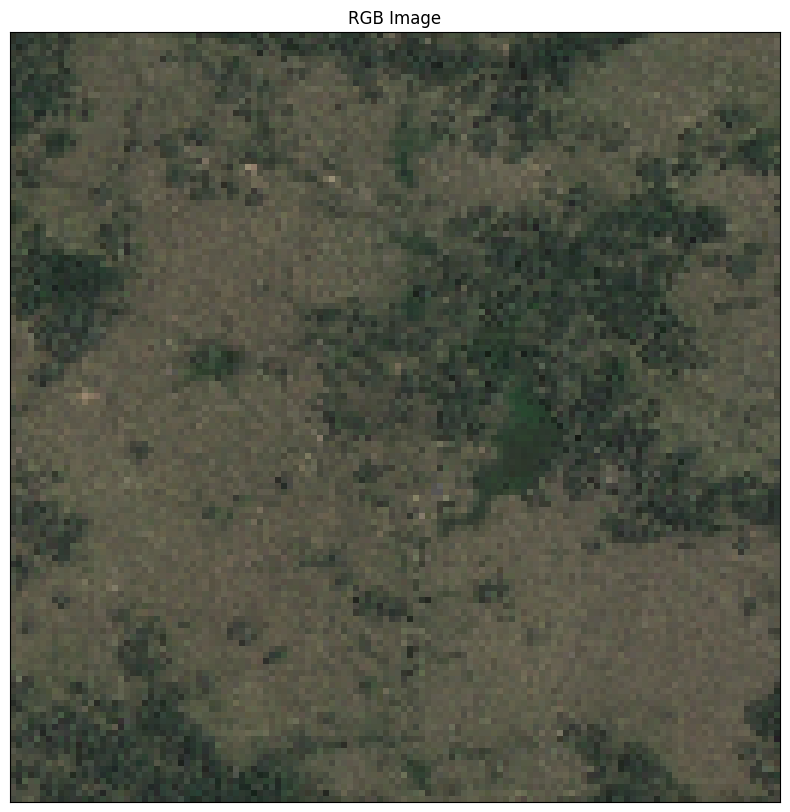

776988
else
else


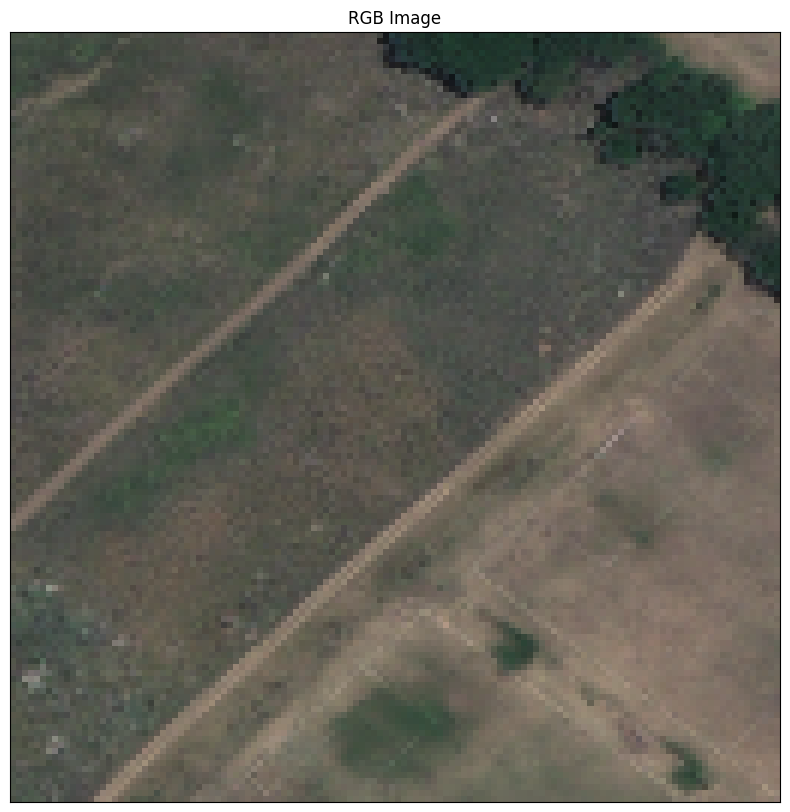

1039548
else
else


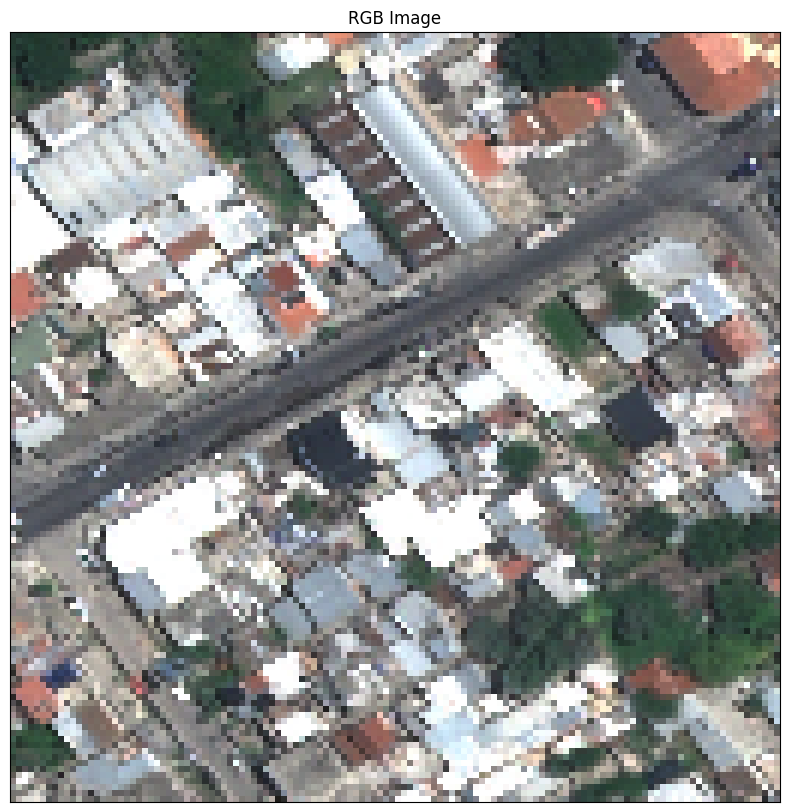

1380576
else
else


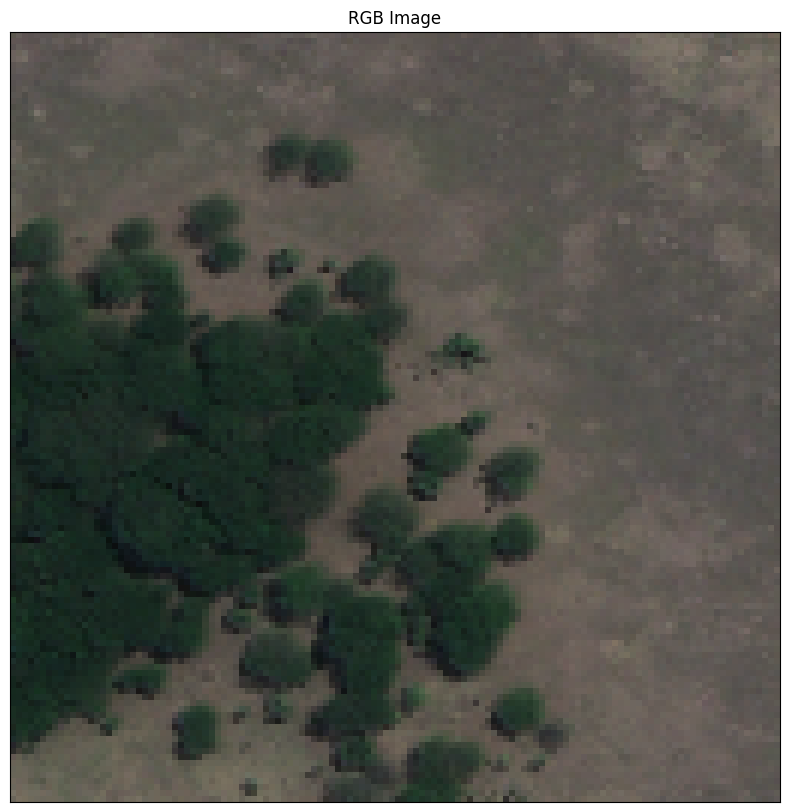

1333312
else
else


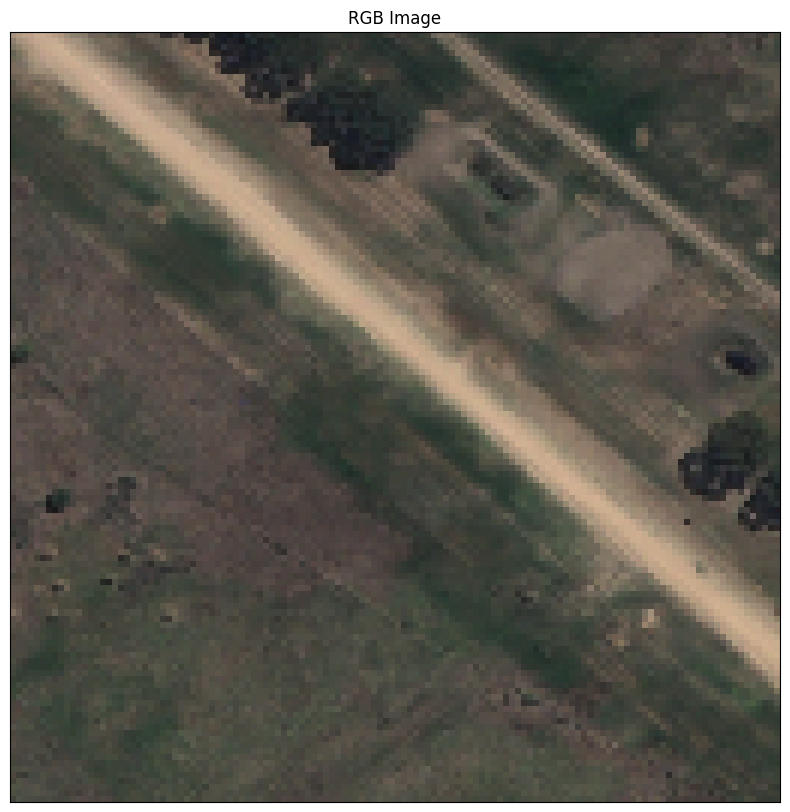

585756
else
else


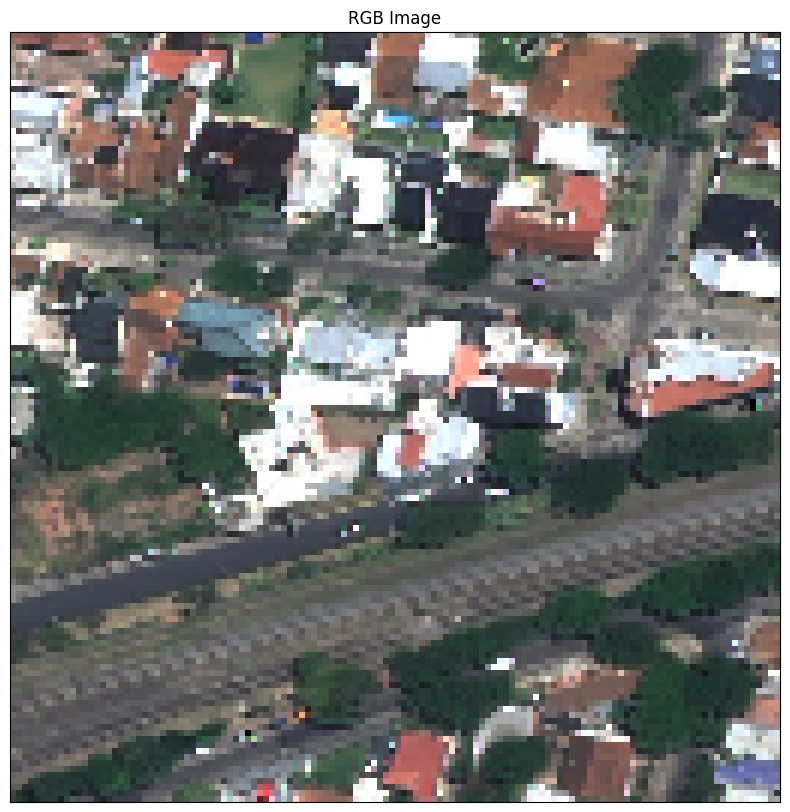

995247
else
else


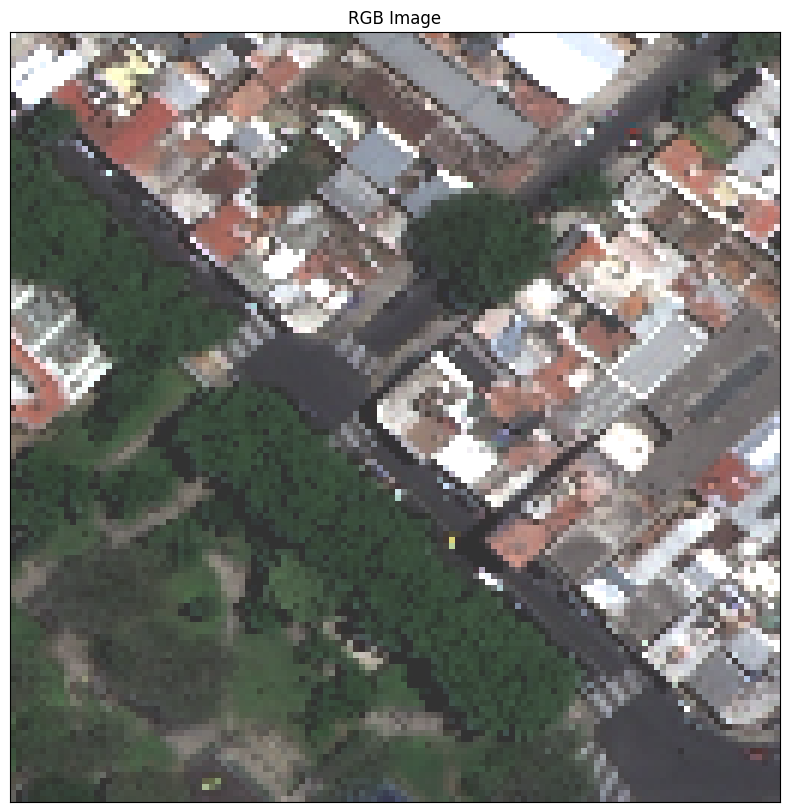

1324222
else
else


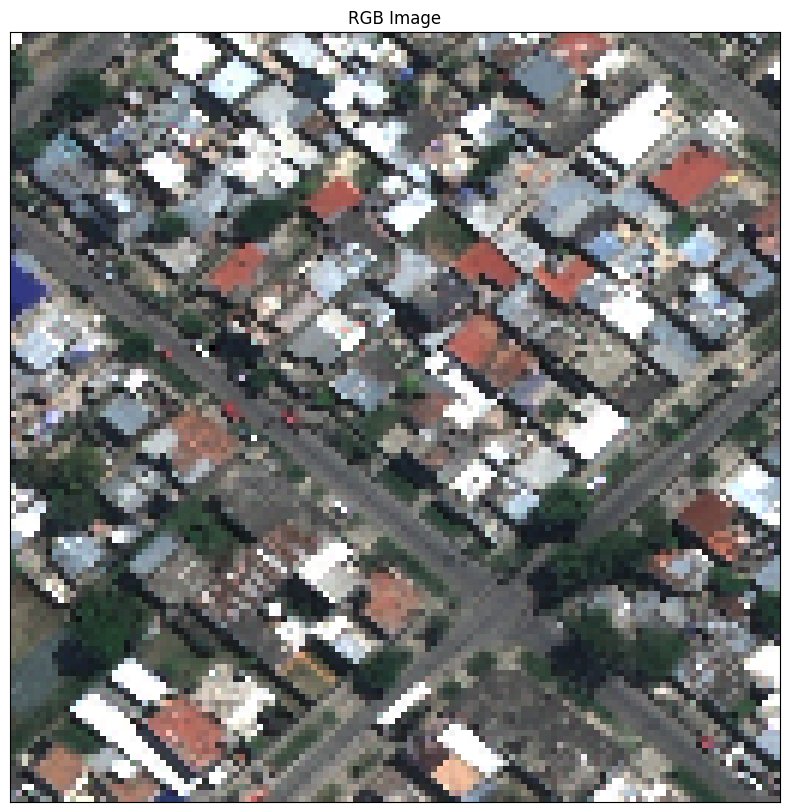

683621
else
else


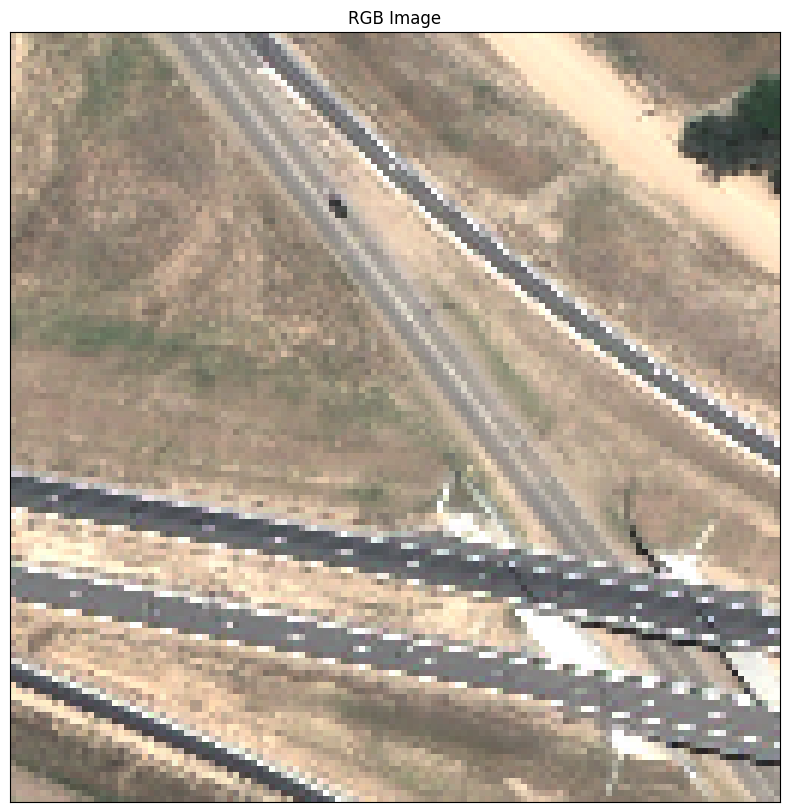

808159
else
else


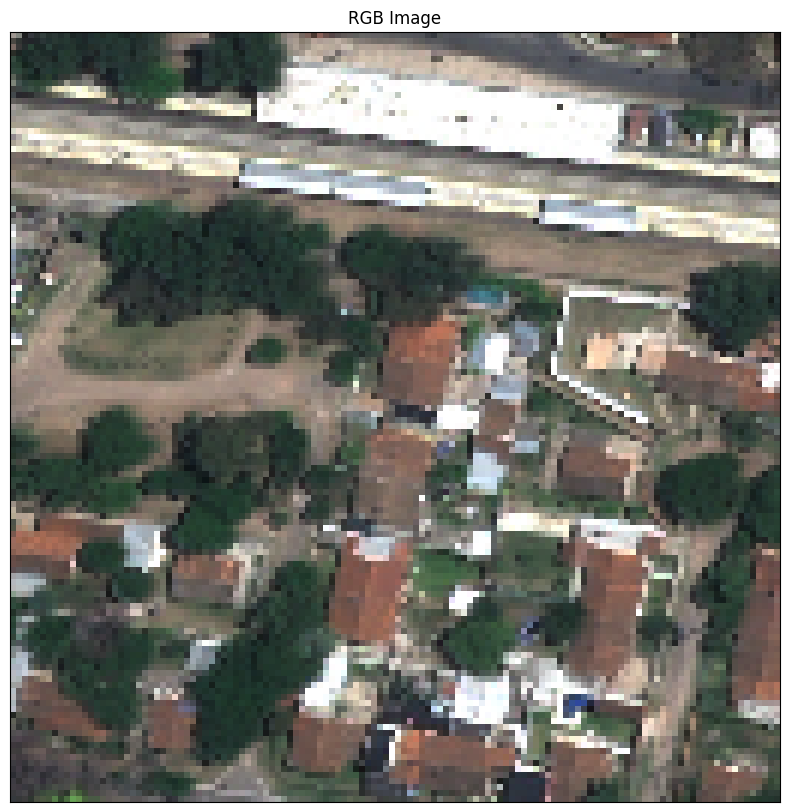

876972
else
else


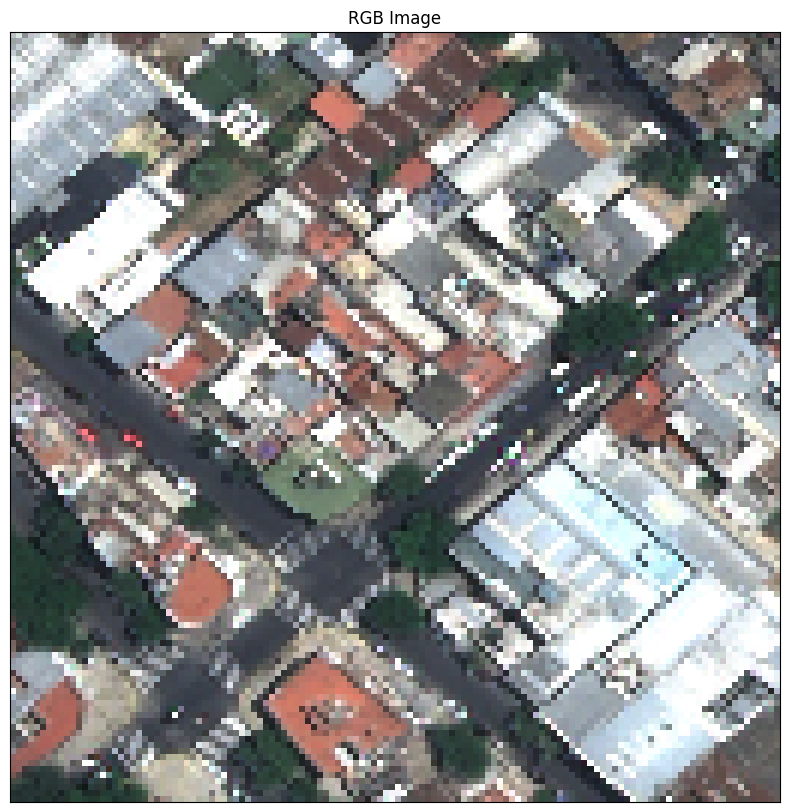

519316
else
else


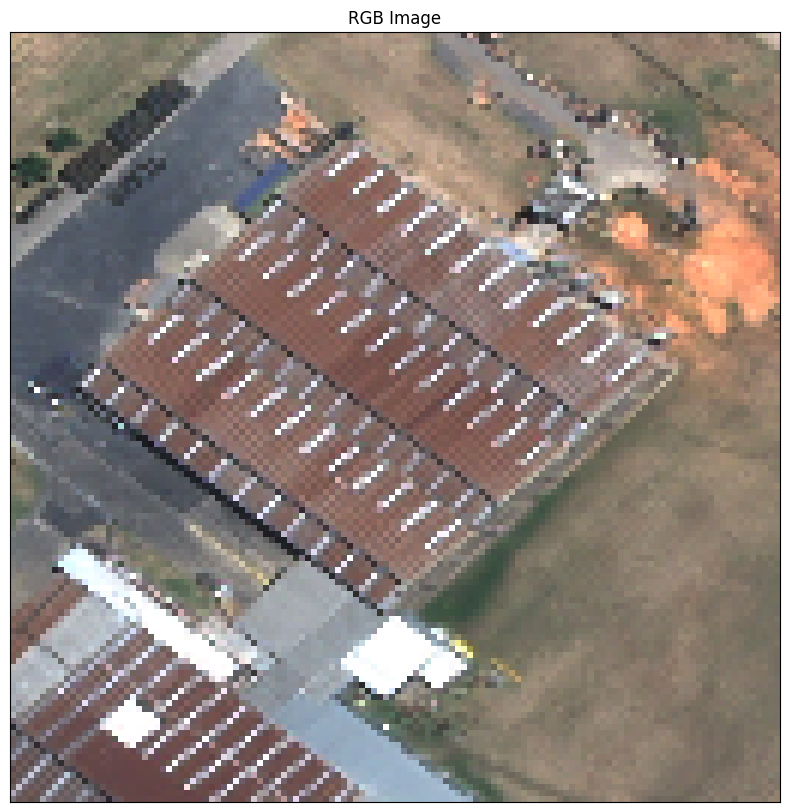

855725
else
else


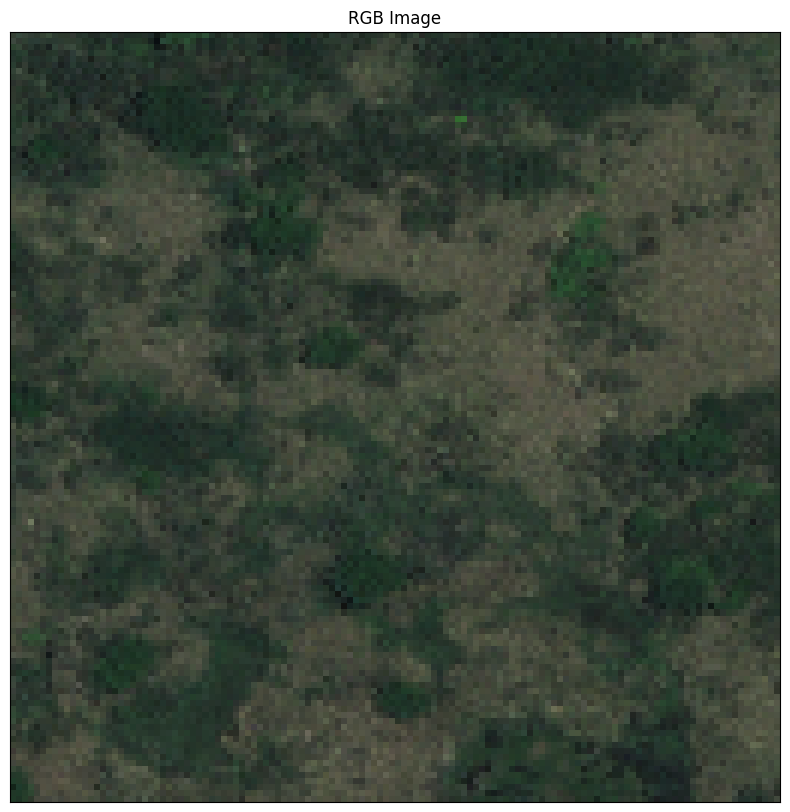

1550516


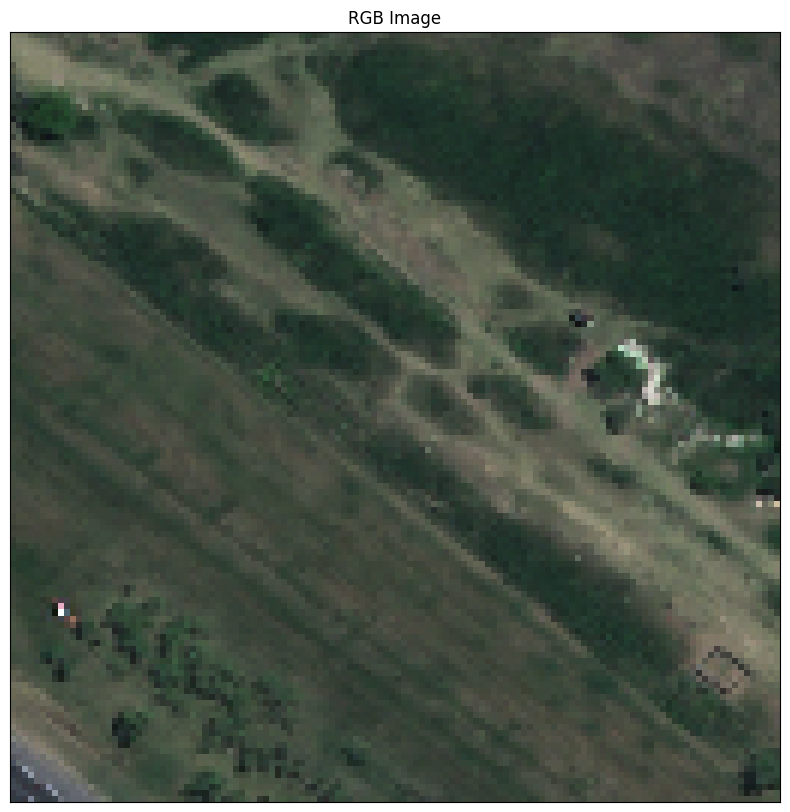

1261978


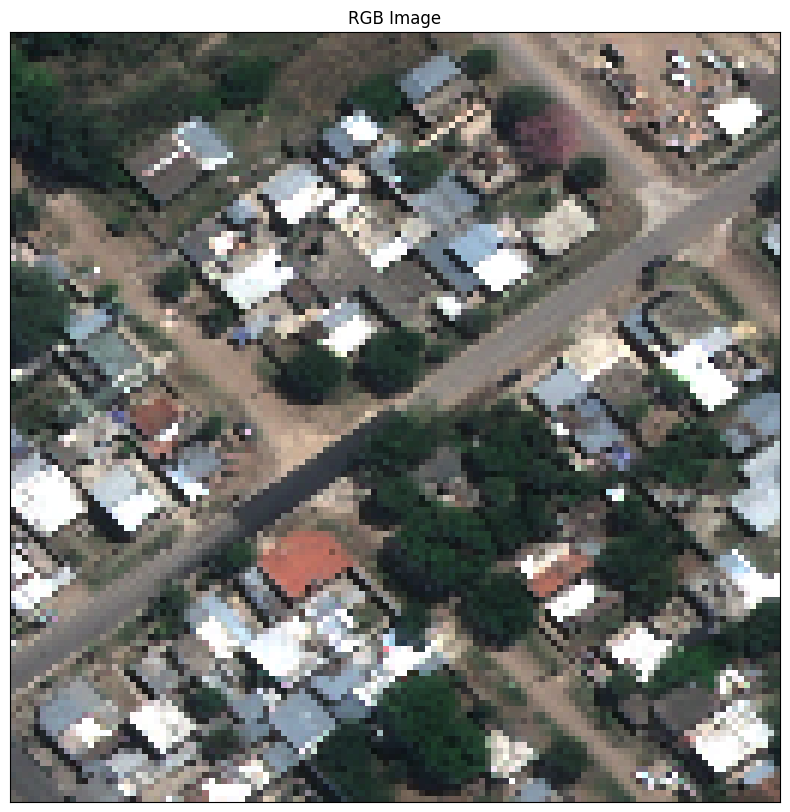

1305187
else
else


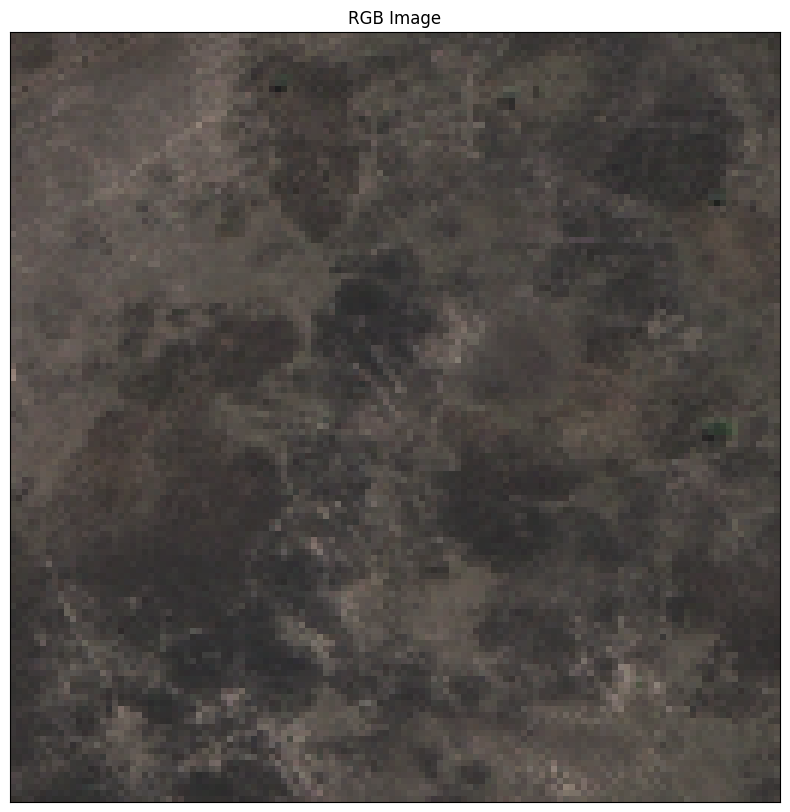

875741
else
else


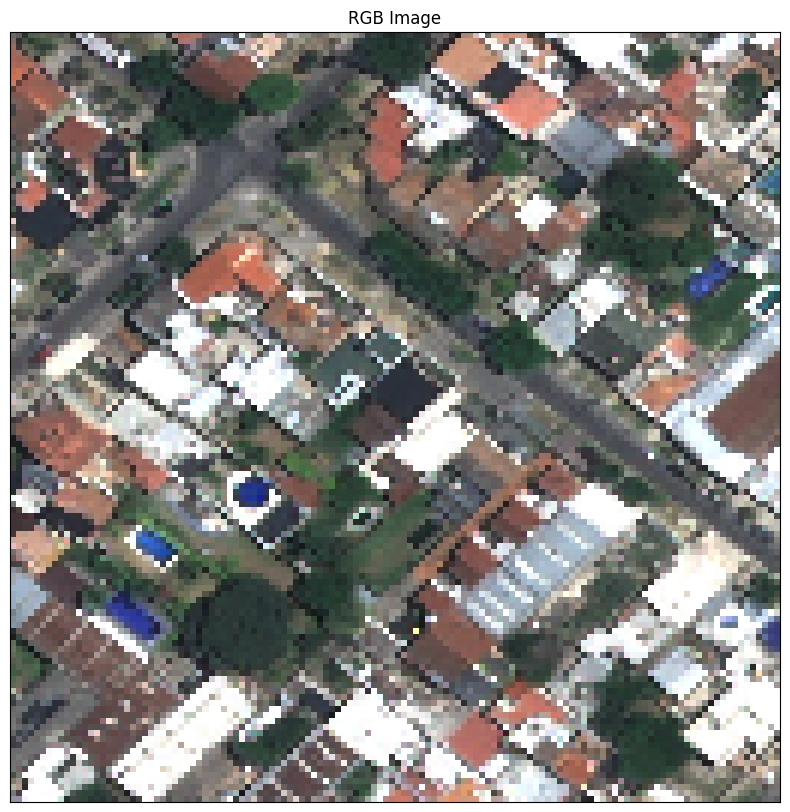

860458
else
else


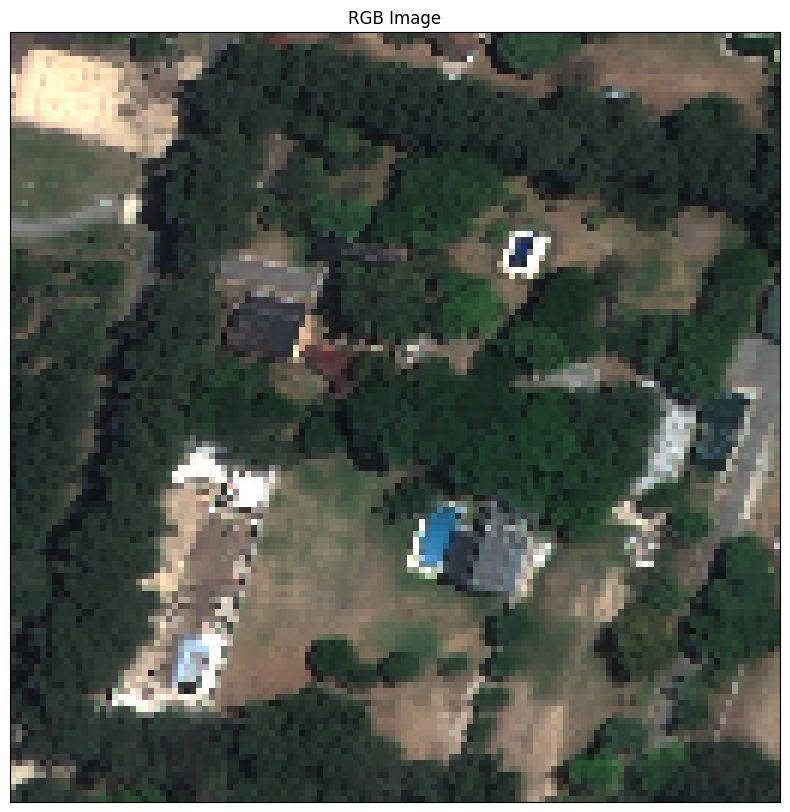

950566


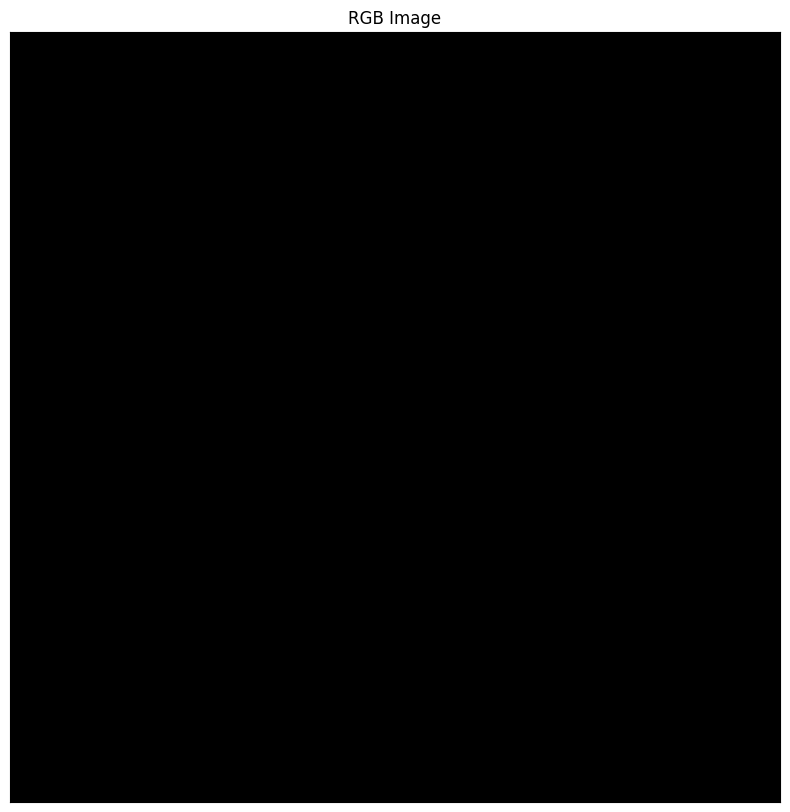

551002
else
else


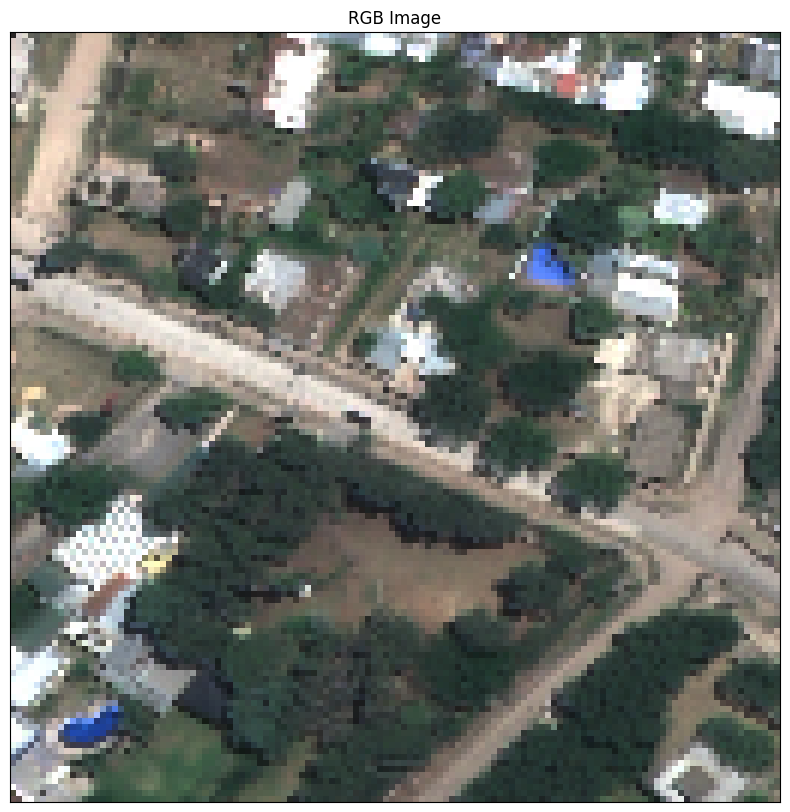

572463
else
else


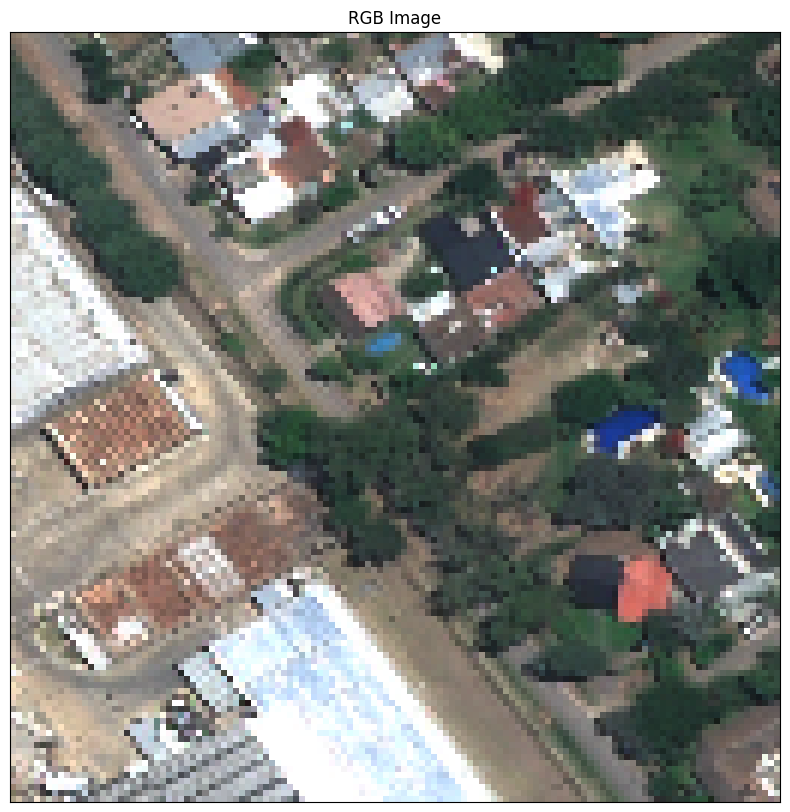

942414
else
else


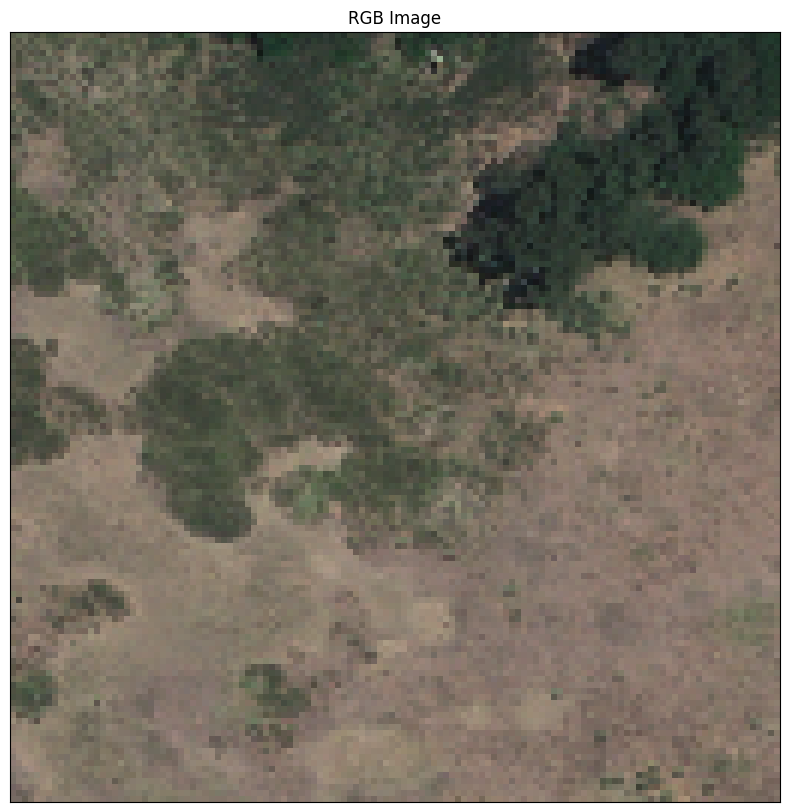

1405105
else
else


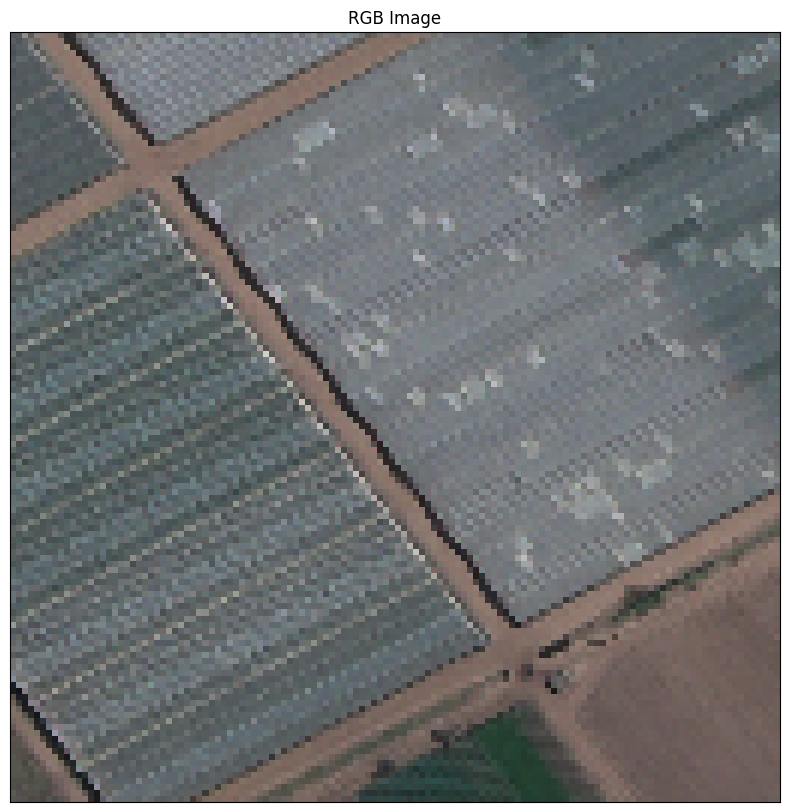

1260962


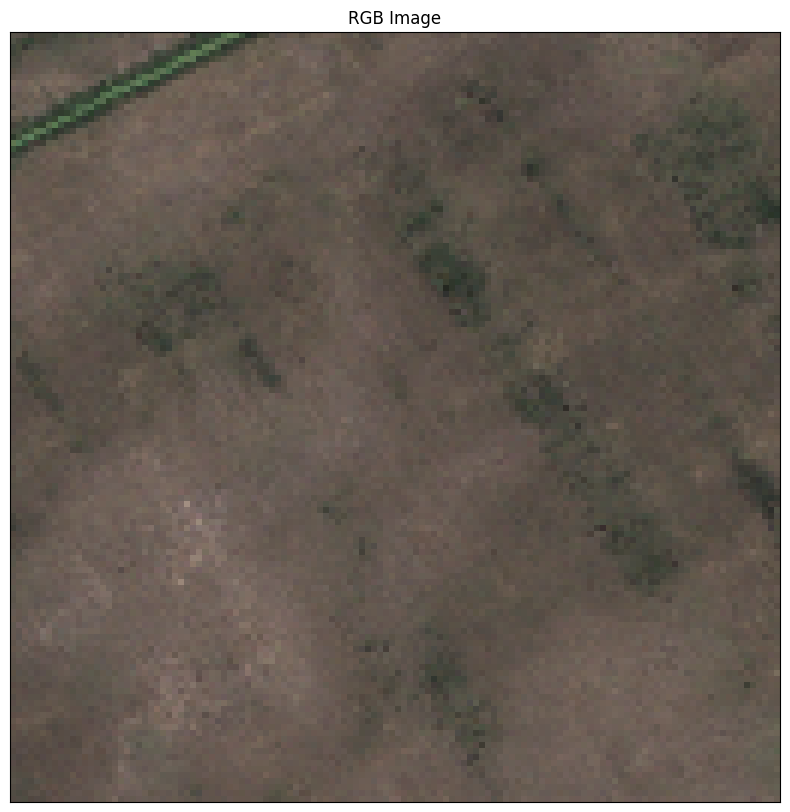

1539013
else
else


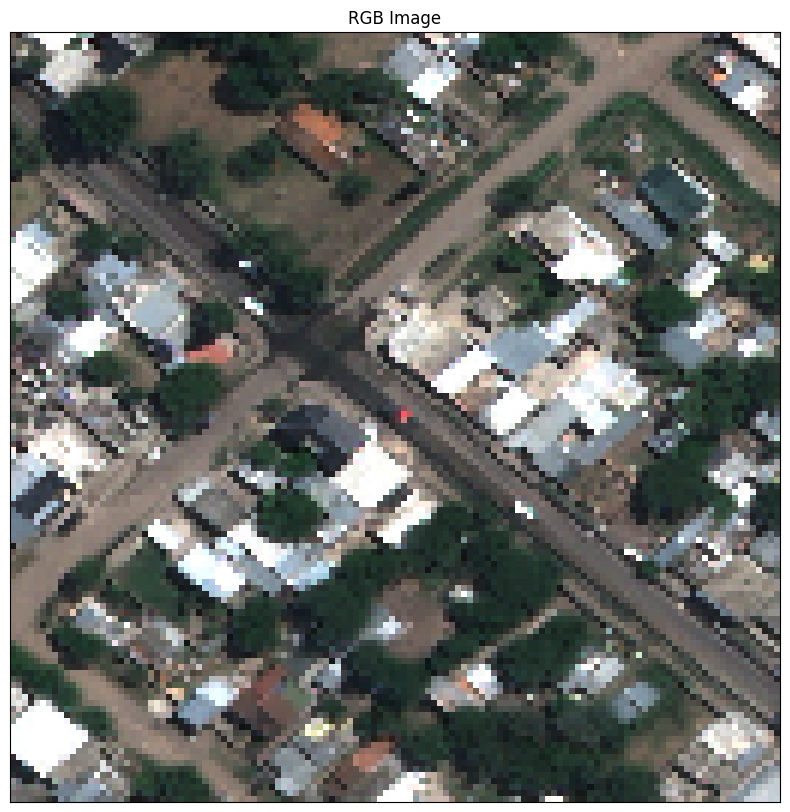

1108538
else
else


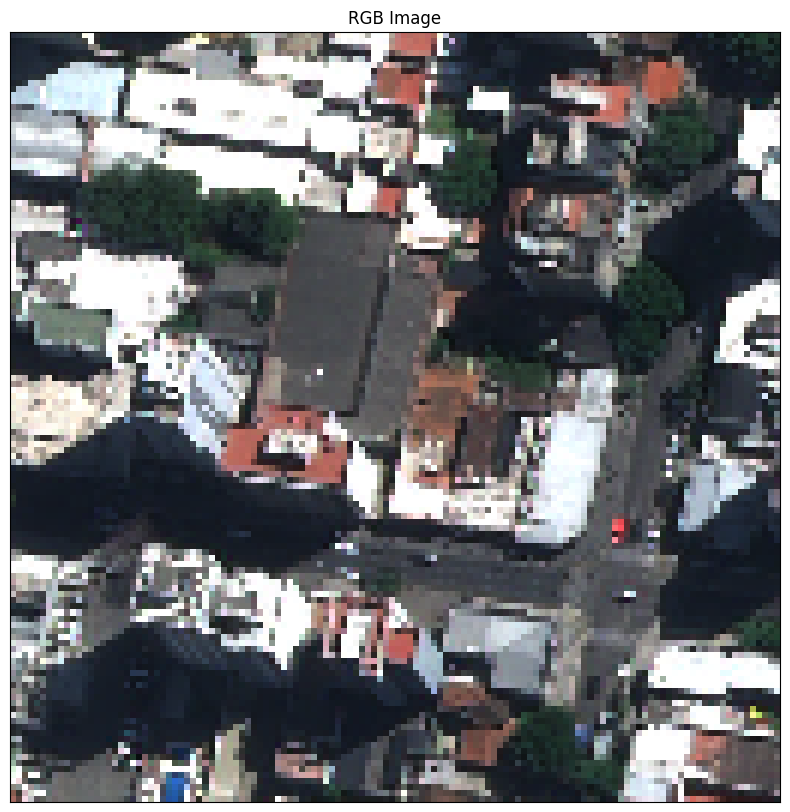

667819
else
else


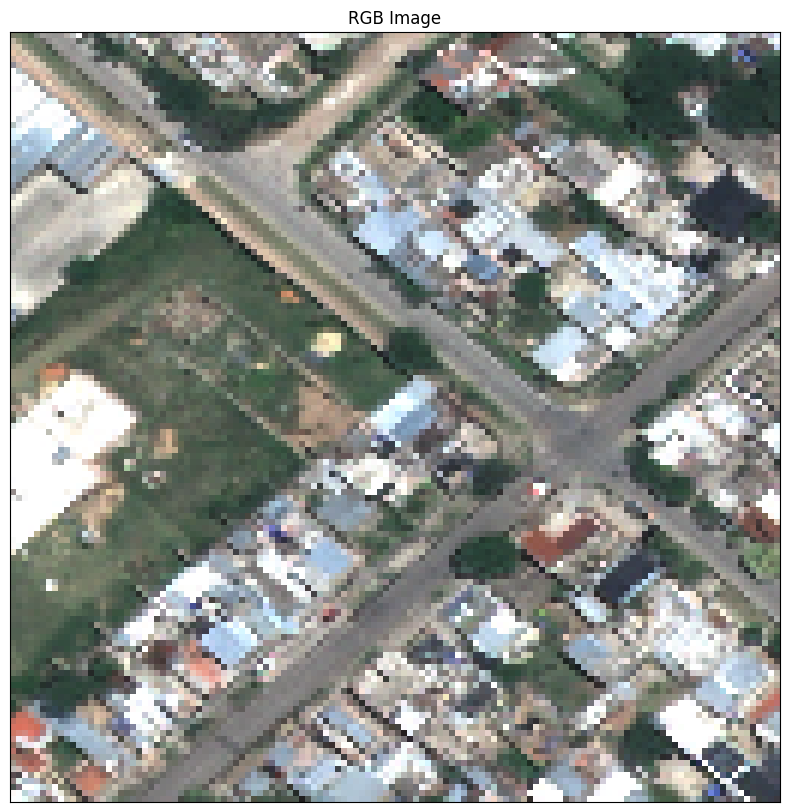

1048963
else
else


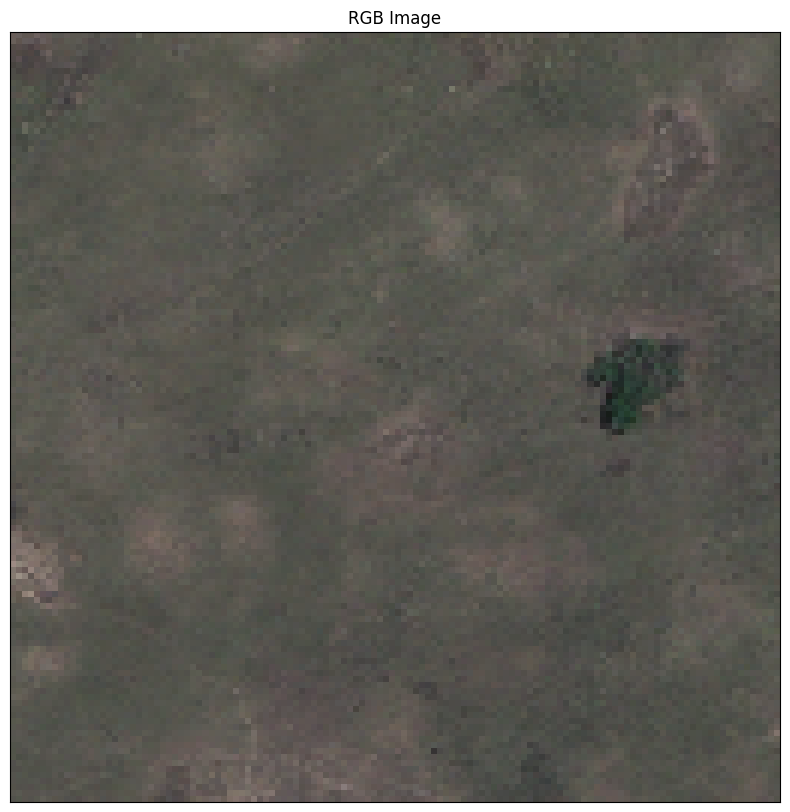

866141
else
else


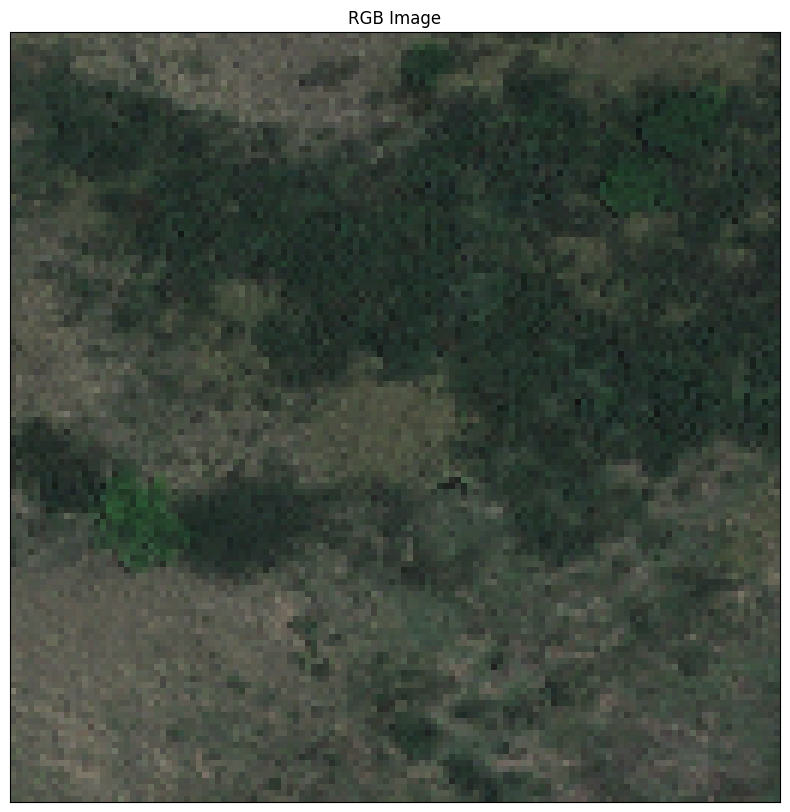

675229
else
else


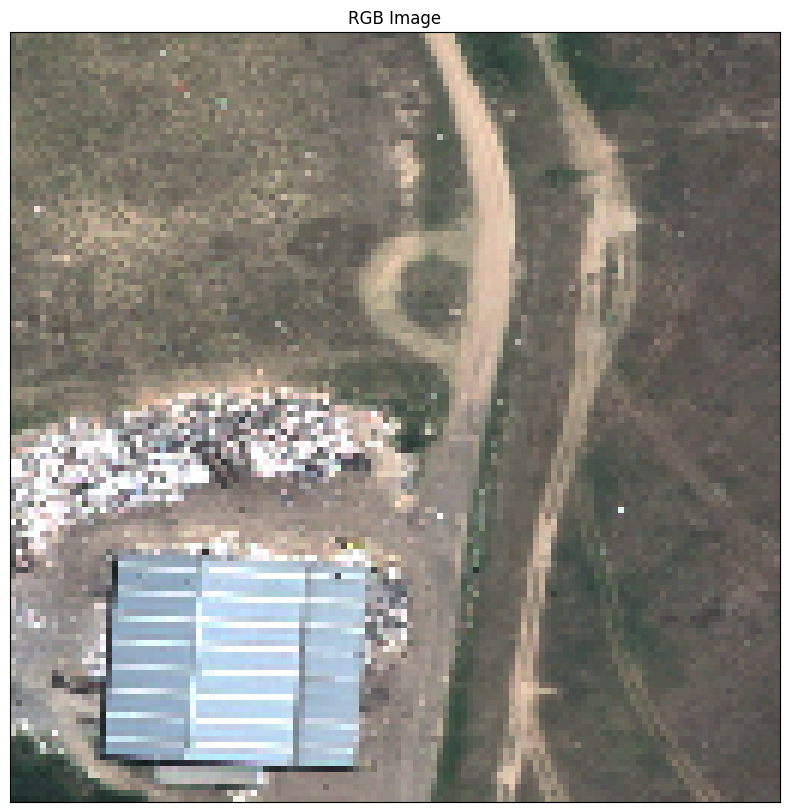

1157870
else
else


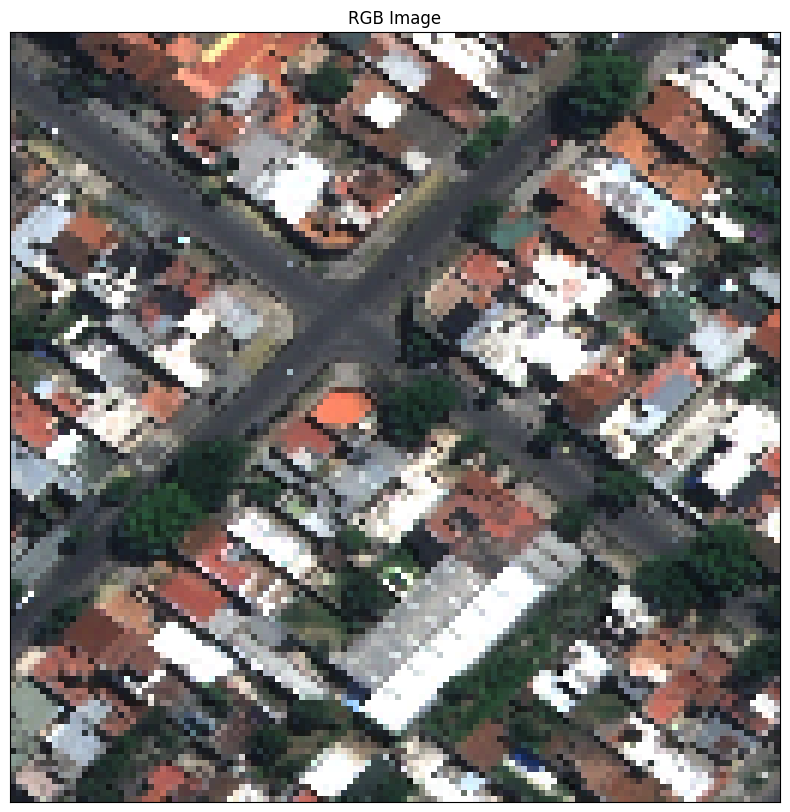

1150446
else
else


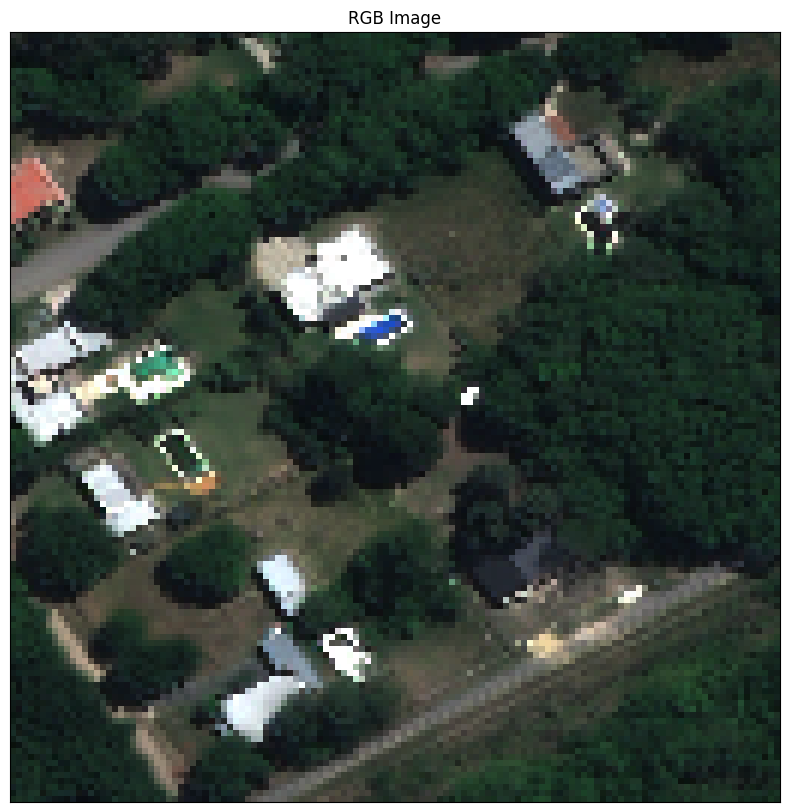

768750
else
'numpy.ndarray' object has no attribute 'to_numpy'
Could not retrieve a valid image for point (-58.55498893900001, -34.469926477) (id: 768750), moving to next image...
739463
else
else


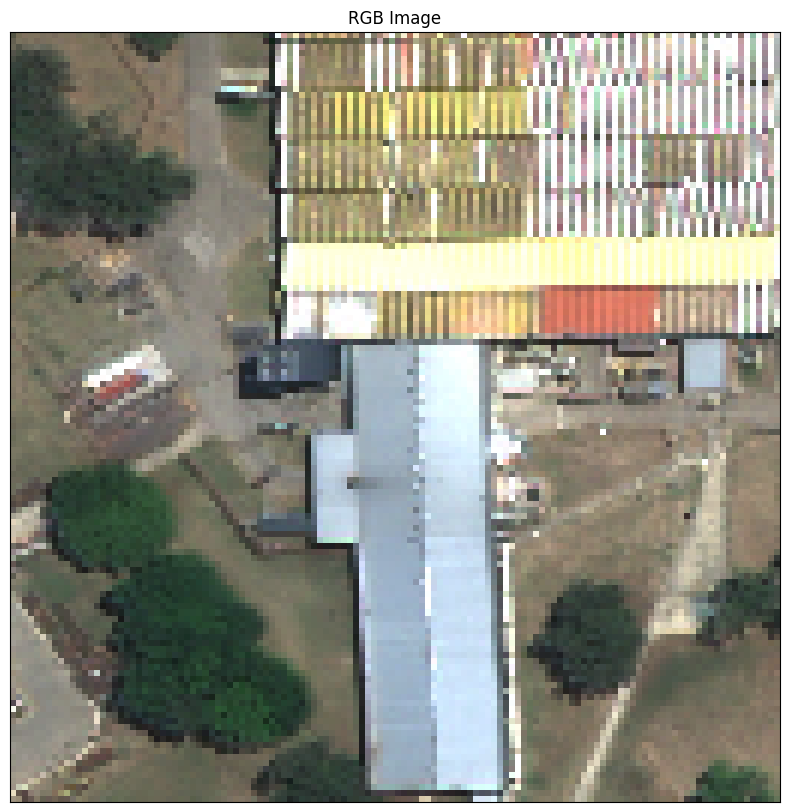

890592
else
else


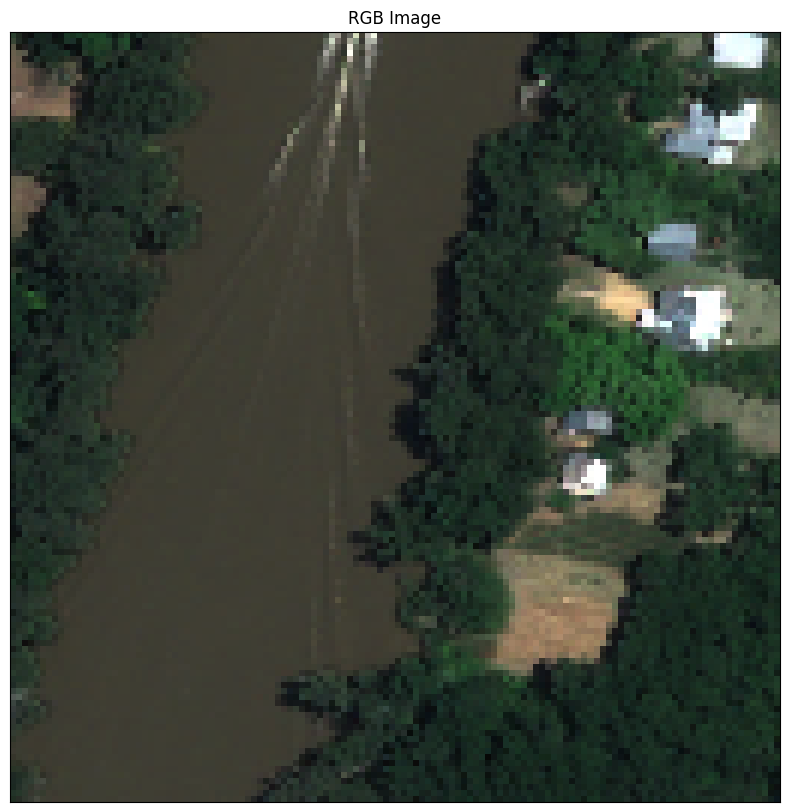

1579184
else
else


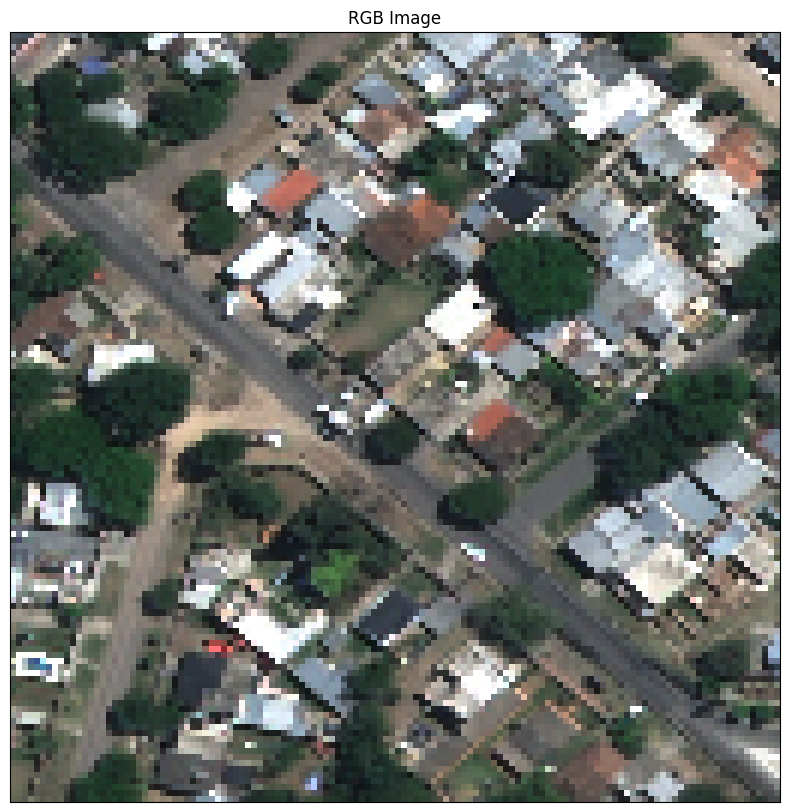

1133102
else
else


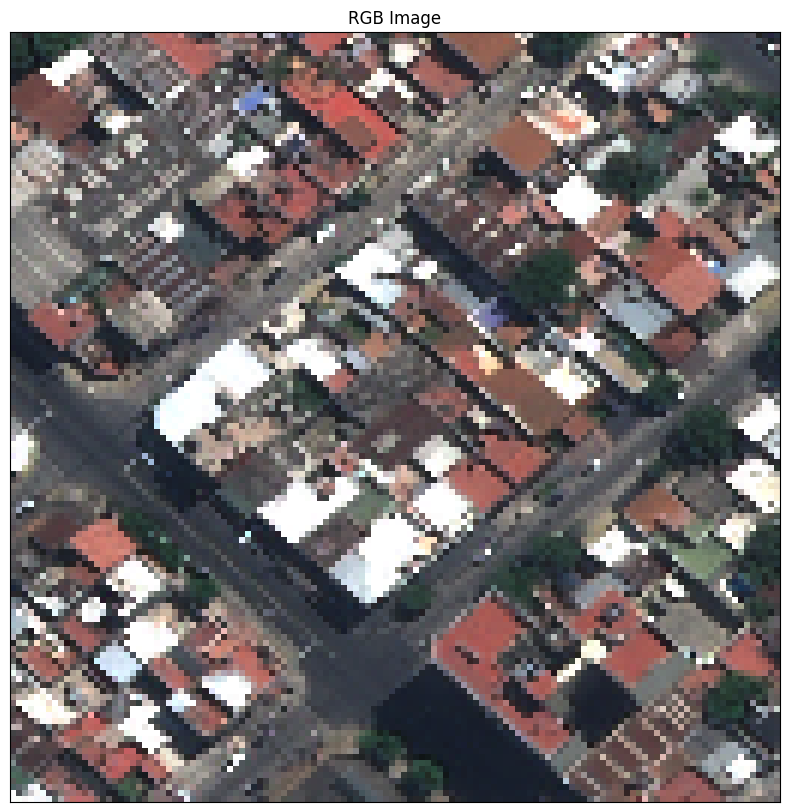

1204884
else
else


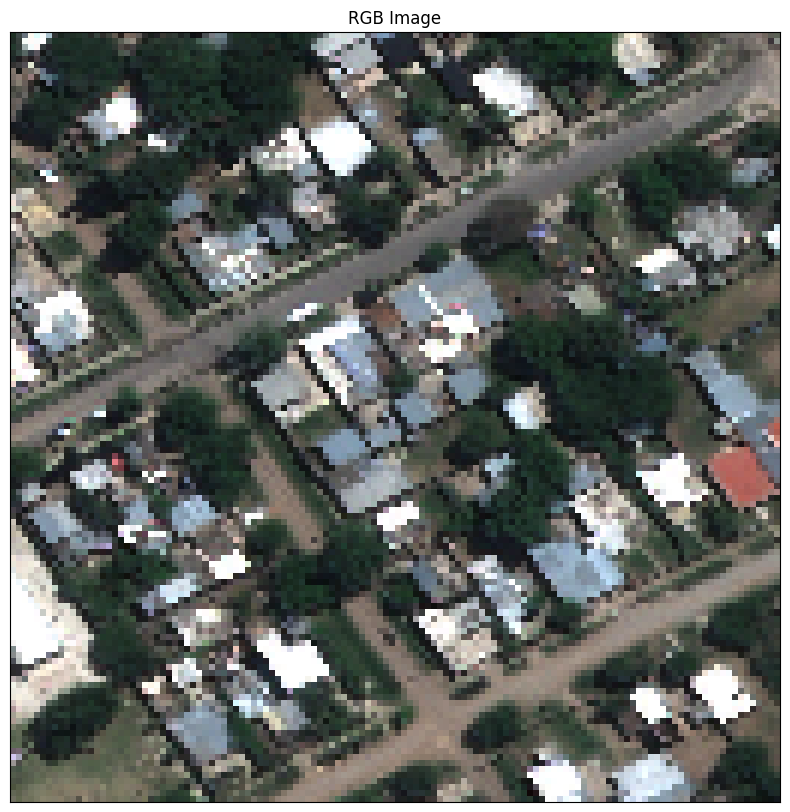

909588
else
else


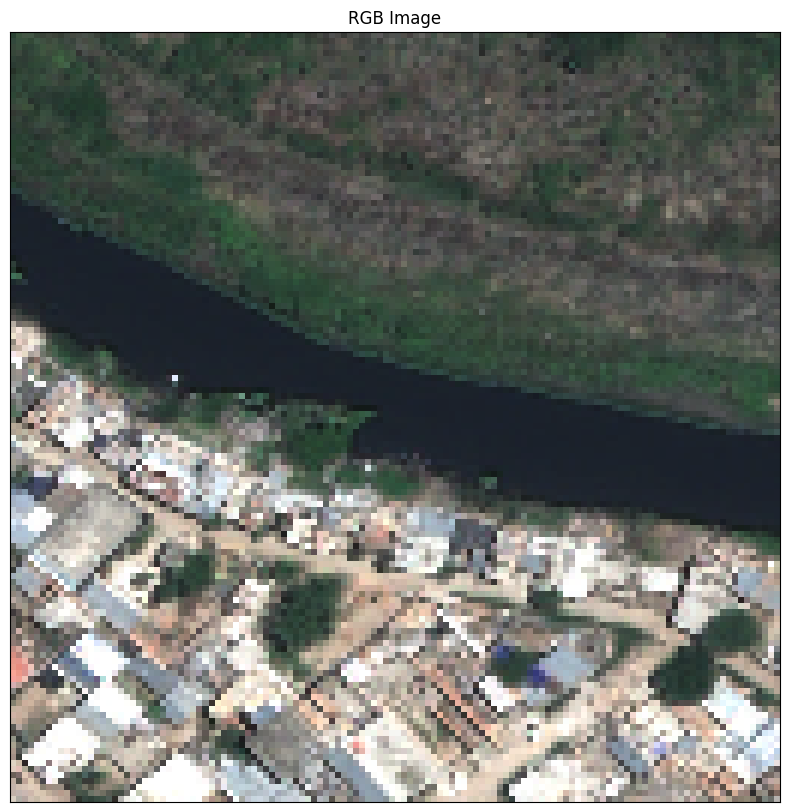

1034890
else
else


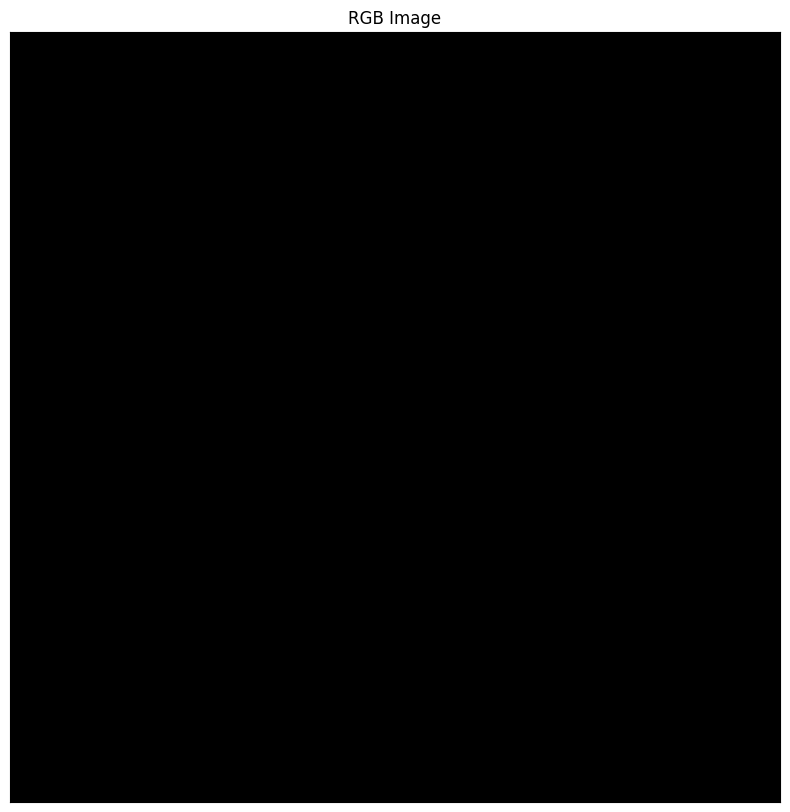

1140994


KeyboardInterrupt: 

In [7]:
import numpy as np
import  earthpy.plot as ep
i=0
while i<500:
    id_point = grid.sample().id.squeeze()
    print(id_point)
    n_bands = 4
    stacked_images = [1, 4]
    year = 2022
    size = 128

    image = np.zeros(shape=(n_bands, 0, 0))
    total_bands = n_bands * len(stacked_images)

    # Get link, dataset and indicator value of the corresponding index
    raster_point = grid[grid["id"] == id_point].point.squeeze()

    # Get data for selected point
    raster_point = (raster_point.x, raster_point.y)

    cell_datasets = build_dataset.get_dataset_for_gdf(
        grid, year_datasets, id_point, year=year, id_var="id"
    )
    image, _ = utils.stacked_image_from_census_tract(
        dataset=cell_datasets,
        polygon=None,
        point=raster_point,
        img_size=size,
        n_bands=n_bands,
        stacked_images=stacked_images,
    )
    if image.shape != (total_bands, size, size):
        print(
            f"Could not retrieve a valid image for point {raster_point} (id: {id_point}), moving to next image..."
        )
        image = np.zeros(shape=(size, size, total_bands))
    else:
        ep.plot_rgb(image, rgb=[4, 5, 6], title="RGB Image")
    i += 1
    # image = utils.image_from_point_dss(cell_datasets, raster_point, size)

In [409]:
image

array([[[0.]],

       [[0.]],

       [[0.]],

       [[0.]]])

In [405]:
importlib.reload(utils)

d:\Maestría\Tesis\Repo\scripts\utils.py:91: DeprecationWarning:

invalid escape sequence '\('



<module 'utils' from 'd:\\Maestría\\Tesis\\Repo\\scripts\\utils.py'>

In [406]:
cosas = utils.dataset_for_image_at_bound(cell_datasets, raster_point, 128)

In [397]:
0 in cosas[0].band_data.shape

True

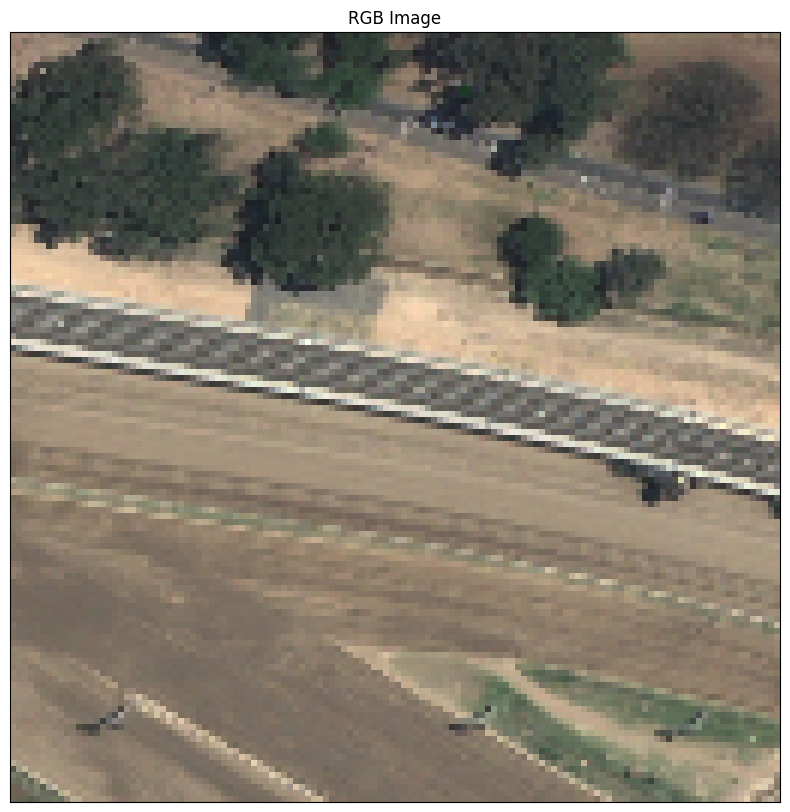

<Axes: title={'center': 'RGB Image'}>

In [350]:
ep.plot_rgb(image, rgb=[4, 5, 6], title="RGB Image")

In [218]:
importlib.reload(build_dataset)
year_datasets, extents = build_dataset.load_satellite_datasets(year=2022)

\\wsl.localhost\UbuntuE\home\nico\data/2022


In [232]:
raster_point

(-58.66944893900001, -34.49293647700003)

In [323]:
def dataset_for_image_at_bound(datasets, point, img_size=512):

    raster_size_x = (datasets[0].x[1] - datasets[0].x[0]).values
    raster_size_y = (datasets[0].y[1] - datasets[0].y[0]).values
    composition = []
    for dataset in datasets:
        filtered_ds = dataset.sel(
            x=slice(  # Add a little buffer and then remove the exceding data
                point[0] - raster_size_x * img_size * 20,
                point[0] + raster_size_x * img_size * 20,
            ),
            y=slice(
                point[1] - raster_size_y * img_size * 20,
                point[1] + raster_size_y * img_size * 20,
            ),
        )
        composition += [filtered_ds]

    if len(composition) > 1:
        composed_dataset = xr.combine_by_coords(composition, combine_attrs="override")
    else:
        composed_dataset = composition[0]

    return composed_dataset

In [327]:
import xarray as xr

dataset=cell_datasets
polygon=None
point=raster_point
img_size=128
n_bands=n_bands
stacked_images=stacked_images

images_to_stack = []
total_bands = n_bands * len(stacked_images)

if point is None:
    # Sample point from the polygon's box
    point = utils.random_point_from_geometry(polygon)
    # point = polygon.centroid.x, polygon.centroid.y

for size_multiplier in stacked_images:
    image_size = img_size * size_multiplier
    print(image_size)
    image_ds = dataset_for_image_at_bound(dataset, point, image_size)
    image = utils.image_from_point(image_ds, point, img_size=image_size)
    print(image.shape)
#         image = image_da.to_numpy()[:n_bands, ::size_multiplier, ::size_multiplier]
#         # print(image)
#         image = np.nan_to_num(image)
#         image = image.astype(np.uint8)
#         images_to_stack += [image]
#     except Exception as e:
#         print(e)
#         image = np.zeros(shape=(n_bands, 1, 1))
#         bounds = None

# # Get total bounds
# bounds = utils.get_image_bounds(image_da)  # The last image has to be the bigger
# image = np.concatenate(images_to_stack, axis=0)  # Concat over bands
# assert image.shape == (total_bands, img_size, img_size)


128
(4, 128, 128)
512
(1, 1, 1)


In [328]:
image_ds

<xarray.Dataset> Size: 2GB
Dimensions:      (band: 4, x: 7778, y: 18606)
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 62kB -58.67 -58.67 -58.67 ... -58.65 -58.65 -58.65
  * y            (y) float64 149kB -34.47 -34.47 -34.47 ... -34.52 -34.52 -34.52
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 2GB ...

In [325]:
utils.image_from_point(image_ds, point, img_size=128)

<xarray.DataArray 'band_data' (band: 4, y: 128, x: 128)> Size: 262kB
[65536 values with dtype=float32]
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 1kB -58.67 -58.67 -58.67 ... -58.67 -58.67 -58.67
  * y            (y) float64 1kB -34.49 -34.49 -34.49 ... -34.49 -34.49 -34.49
    spatial_ref  int32 4B ...
Attributes:
    AREA_OR_POINT:  Area

In [313]:
point

(-58.66944893900001, -34.49293647700003)

In [332]:
image_ds.x

<xarray.DataArray 'x' (x: 7778)> Size: 62kB
array([-58.669966, -58.669964, -58.669961, ..., -58.648974, -58.648972,
       -58.648969])
Coordinates:
  * x            (x) float64 62kB -58.67 -58.67 -58.67 ... -58.65 -58.65 -58.65
    spatial_ref  int32 4B ...

In [331]:
# Find the rearest raster of this random point
x, y = point
idx_x = np.searchsorted(image_ds.x, x, side="left", sorter=None)
idx_y = np.searchsorted(
    -image_ds.y, -y, side="left", sorter=None
)  # The y array is inverted! https://stackoverflow.com/questions/43095739/numpy-searchsorted-descending-order

idx_x, idx_y

(192, 7228)

(192, 7228)

In [306]:
image_da

<xarray.Dataset> Size: 10MB
Dimensions:      (band: 4, x: 572, y: 1138)
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 5kB -58.67 -58.67 -58.67 ... -58.67 -58.67 -58.67
  * y            (y) float64 9kB -34.49 -34.49 -34.49 ... -34.49 -34.49 -34.49
    spatial_ref  int32 4B ...
Data variables:
    band_data    (band, y, x) float32 10MB ...

In [201]:
datasets, point, img_size = dataset, point, image_size 

raster_size_x = (datasets[0].x[1] - datasets[0].x[0]).values
raster_size_y = (datasets[0].y[1] - datasets[0].y[0]).values
images = []
for dataset in datasets:
    image = dataset.sel(
        x=slice(  # Add a little buffer and then remove the exceding data
            point[0] - raster_size_x * (img_size + 10) / 2,
            point[0] + raster_size_x * (img_size + 10) / 2,
        ),
        y=slice(
            point[1] - raster_size_y * (img_size + 10) / 2,
            point[1] + raster_size_y * (img_size + 10) / 2,
        ),
    ).isel(x=slice(0, img_size), y=slice(0, img_size))
    images += [image.band_data]

if len(images) > 0:
    image = xr.combine_by_coords(images, combine_attrs="override")
else:
    image = images[0]

image = image.band_data

# If any of the indexes are negative, move to the next iteration
if image.x.size < img_size | image.y.size < img_size:
    image = np.zeros(shape=(1, 1, 1))
    print("Error en imagen")


In [202]:
image

<xarray.DataArray 'band_data' (band: 4, y: 512, x: 453)> Size: 4MB
[927744 values with dtype=float32]
Coordinates:
  * band         (band) int32 16B 1 2 3 4
  * x            (x) float64 4kB -58.67 -58.67 -58.67 ... -58.67 -58.67 -58.67
  * y            (y) float64 4kB -34.49 -34.49 -34.49 ... -34.49 -34.49 -34.49
    spatial_ref  int32 4B ...
Attributes:
    AREA_OR_POINT:  Area

In [ ]:
images_to_stack[1].shape

In [ ]:
images_to_stack[0].shape

In [ ]:
cell_datasets

In [ ]:
image.shape

In [ ]:
importlib.reload(utils)

In [ ]:
raster_size_x = (cell_datasets[0].x[1] - cell_datasets[0].x[0]).values
raster_size_y = (cell_datasets[0].y[1] - cell_datasets[0].y[0]).values


image = cell_datasets[0].sel(
    x=slice(
        raster_point[0] - raster_size_x * (size / 2) ,
        raster_point[0] + raster_size_x *  size / 2,
    ),
    y=slice(
        raster_point[1] - raster_size_y * (size) / 2,
        raster_point[1] + raster_size_y * size / 2,
    ),
).isel(x=slice(0, size), y=slice(0, size))
image


In [ ]:
datasets[=]

In [ ]:
cell_datasets

In [ ]:
build_dataset.get_dataset_for_gdf(
    grid, datasets, 515256, year=2022, id_var="id"
)

In [ ]:
grid.loc[grid["id"] == 515256, f"dataset_2022"]

In [ ]:
current_ds_name = grid.loc[grid["id"] == id_point, f"dataset_2022"].iloc[0]
current_ds_name

In [ ]:
image, _ = utils.stacked_image_from_census_tract(
    dataset=cell_datasets,
    polygon=None,
    point=raster_point,
    img_size=size,
    n_bands=n_bands,
    stacked_images=stacked_images,
)


In [ ]:
datasets, extents = build_dataset.load_satellite_datasets(year=2022)


In [ ]:
import build_dataset
import geopandas as gpd

datasets, extents = build_dataset.load_satellite_datasets(year=2022)
grid = gpd.read_parquet(r"D:\Maestría\Tesis\Repo\data\data_in\Grillas\grid_size128_tiles1.parquet")
grid = build_dataset.assign_datasets_to_gdf(
    grid, extents, year=2022, select="all_matches", verbose=False
)
grid.dropna(subset=["dataset_2022"], inplace=True)

In [ ]:
grid["dataset_2022"].apply(lambda x: len(x)).value_counts()

In [ ]:
type(grid.loc[grid.id == 515256,"dataset_2022"].iloc[0]) == list

In [ ]:
ataset.assign_datasets_to_gdf(
    grid, extents, year=year, select="all_matches", verbose=False
)


In [ ]:
grid["dataset_2022"]

In [ ]:
grid.loc[grid.id == row_id, "dataset_2022"].iloc[0]

In [ ]:
def image_from_point_dss(datasets, point, img_size=128):

    raster_size_x = (datasets[0].x[1] - datasets[0].x[0]).values
    raster_size_y = (datasets[0].y[1] - datasets[0].y[0]).values
    images = []
    for dataset in datasets:
        image = dataset.sel(
            x=slice(
                point[0] - raster_size_x * (img_size-1)/2, 
                point[0] + raster_size_x *  img_size   /2,
            ), 
            y=slice(
                point[1] - raster_size_y * (img_size-1)/2, 
                point[1] + raster_size_y *  img_size   /2,
            ), 
        )
        if 0 in image.band_data.shape:
            # Datasets doesn't contain image
            continue
        images += [image.band_data]

    image = xr.combine_by_coords(images, combine_attrs="override")
    
    # If any of the indexes are negative, move to the next iteration
    if (
        image.x.size < img_size |
        image.y.size < img_size
    ):
        image = np.zeros(shape=(1, 1, 1))
        print("Error en imagen")
        return image


    # if image.chunks is not None:
    #     # If the image is not computed, compute it
    #     image = image.compute()

    return image


In [ ]:
def image_from_point(dataset, point, img_size=128):

    raster_size_x = (dataset.x[1] - dataset.x[0]).values
    raster_size_y = (dataset.y[1] - dataset.y[0]).values
    image = dataset.sel(
        x=slice(
            point[0] - raster_size_x * (img_size-1)/2, 
            point[0] + raster_size_x *  img_size   /2,
        ), 
        y=slice(
            point[1] - raster_size_y * (img_size-1)/2, 
            point[1] + raster_size_y *  img_size   /2,
        ), 
    )
    image = image.band_data
    
    # If any of the indexes are negative, move to the next iteration
    if (
        image.x.size < img_size |
        image.y.size < img_size
    ):
        image = np.zeros(shape=(1, 1, 1))
        return image


    # if image.chunks is not None:
    #     # If the image is not computed, compute it
    #     image = image.compute()

    return image


In [ ]:
image_from_point(ds, (x_max, y_min), img_size=512)

In [ ]:
datasets = [ds, ds_up, ds_right]
for dataset in datasets:
    dataset["x"] = dataset.x.round(6)
    dataset["y"] = dataset.y.round(6)

In [ ]:
%%timeit
image_from_point(dataset, (x_max, y_min), img_size=512)

In [ ]:
%%timeit
image_from_point_dss(datasets, (x_max, y_min), img_size=512)

In [ ]:
point = (x_max, y_min)
img_size = 512
datasets = [ds, ds_up, ds_right]
raster_size_x = (datasets[0].x[1] - datasets[0].x[0]).values
raster_size_y = (datasets[0].y[1] - datasets[0].y[0]).values
images = []
for dataset in datasets:
    dataset["x"] = dataset.x.round(6)
    dataset["y"] = dataset.y.round(6)
    image = dataset.sel(
        x=slice(
            point[0] - raster_size_x * (img_size-1)/2, 
            point[0] + raster_size_x *  img_size   /2,
        ), 
        y=slice(
            point[1] - raster_size_y * (img_size-1)/2, 
            point[1] + raster_size_y *  img_size   /2,
        ), 
    )
    if 0 in image.band_data.shape:
        # Datasets doesn't contain image
        continue

    images += [image.band_data]
    print("loop")
image = xr.combine_by_coords(images, combine_attrs="override")

plot_rgb(image.band_data.values, rgb=[0, 1, 2])

In [ ]:
dataset.x.round(6)

In [ ]:
plot_rgb(images[1].values)

In [ ]:
images[1].y.values

In [ ]:
print(images[0].y.values[0])
print(images[1].y.values[0])
images[0].y.values[0] == images[1].y.values[0]

In [ ]:
images[1].y

In [ ]:
xr.combine_nested([images[0], images[1]], concat_dim=["x"])

In [ ]:
plot_rgb(images[0].values)

In [ ]:
xr.combine_by_coords(images, combine_attrs="override")

In [ ]:
raster_size_x = (images[1].x[1] - images[1].x[0]).values
raster_size_y = (images[1].y[1] - images[1].y[0]).values

raster_size_x0 = (images[0].x[1] - images[0].x[0]).values
raster_size_y0 = (images[0].y[1] - images[0].y[0]).values

raster_size_x0 == raster_size_x

In [ ]:
images[0]

In [ ]:
image

In [ ]:
0 in image.band_data.shape

In [ ]:
raster_size_x = (datasets[0].x[1] - datasets[0].x[0]).values
raster_size_y = (datasets[0].y[1] - datasets[0].y[0]).values
images = []
for dataset in datasets:
    image = dataset.sel(
        x=slice(
            point[0] - raster_size_x * (img_size-1)/2, 
            point[0] + raster_size_x *  img_size   /2,
        ), 
        y=slice(
            point[1] - raster_size_y * (img_size-1)/2, 
            point[1] + raster_size_y *  img_size   /2,
        ), 
    )
    images += [image.band_data]
image = xr.combine_by_coords([images], combine_attrs="override")


In [ ]:
from earthpy.plot import plot_rgb

up = ds_up.sel(x=slice(-58.556, -58.554), y=slice(-34.415169, -34.416506))
down = ds.sel(x=slice(-58.556, -58.554), y=slice(-34.415169, -34.416506))
right = ds.sel(x=slice(-58.556, -58.554), y=slice(-34.415169, -34.416506))

plot_rgb(xr.combine_by_coords([up, down, right], combine_attrs="override").band_data.values, rgb=[0, 1, 2])

In [ ]:
xr.open_mfdataset([filename, filename_up]).sel(x=slice(x_min, x_min+0.005), y=slice(y_min+0.005, y_min)).compute()

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    merged = xr.combine_by_coords([ds, ds_up])
    merged.to_netcdf("E:\my_test.nc")
merged

In [ ]:
ds_up

In [ ]:
ds_up

In [ ]:
import os

# for capture_id, files in files_by_id.items():
capture_id = "202211031357171"
files = os.listdir(rf"\\wsl.localhost\UbuntuE\home\nico\data\2022")
files = [f for f in files if f.endswith(".tif")]
id_files = [rf"\\wsl.localhost\UbuntuE\home\nico\data\2022\{f}" for f in files if capture_id in f]
id_files_matrix = generate_matrix_of_files(id_files)

ds = xr.open_mfdataset(
    id_files_matrix[0],
    combine="nested",
    concat_dim=["y"],
    engine="rasterio",
    parallel=True,
    chunks={'x': 1000, 'y':1000, 'band':1},
)
ds

In [ ]:
ds = xr.open_dataset(r"E:\pansharpened_202211031357171.nc")
ds.isel(x=slice(-1000, None), y=slice(-1000, None)).band_data.values

In [ ]:
import earthpy.plot as ep

img_size = 128
point = (np.random.choice(ds.x), np.random.choice(ds.y))

image = image_from_point(ds, point, img_size=512)
if image.max() != 0:  
    image = image.values  
    ep.plot_rgb(image, rgb=[0, 1, 2], title="RGB Image")


In [ ]:
image_from_point(ds, point, img_size=512)

In [ ]:
image_from_point(ds, point, img_size=3000).to_netcdf(r"E:\test_1.nc", encoding={"band_data": {"dtype": np.uint8}})
image_from_point(ds, point, img_size=3000).to_netcdf(r"E:\test_2.nc", encoding={"band_data": {"dtype": np.uint8, "zlib": True, "complevel": 5, "chunksizes": (1, 1000, 1000)}})

In [ ]:
image_from_point(ds, point, img_size=3000)

In [ ]:
import numpy as np
from dask.diagnostics import ProgressBar

with ProgressBar():
    ds.band_data.to_netcdf(r"E:\pansharpened_202211031357171.nc", encoding={"dtype": np.uint8, "zlib": True, "complevel": 5, "chunksizes": (1, 1000, 1000)}})#, "zlib": True, "complevel": 5, "chunksizes": (1000, 1000, 1)}})

In [ ]:
ds

In [ ]:
mf_ds.band_data.rio.to_raster(r"D:\Maestría\Tesis\Repo\data\data_in\Compressed\2022\pansharpened_6741392101.tif", driver="GTiff", compress="LZW")

In [ ]:
fast_ds = xr.open_dataset(r"\\wsl.localhost\UbuntuE\home\nico\data\2022\pansharpened_202211031357396_R3C2.tif")

In [ ]:
%%timeit

point = (np.random.choice(ds.x), np.random.choice(ds.y))
ds.sel(x=point[0], y=point[1]).compute()
# get_grid_data(point, ds)

In [ ]:
%%timeit
import numpy as np

point = (np.random.choice(fast_ds.x), np.random.choice(fast_ds.y))
fast_ds.sel(x=point[0], y=point[1], method="nearest")
# get_grid_data(point, fast_ds)

In [ ]:
def test_grid_data_fast_ds():
    point = (np.random.choice(fast_ds.x), np.random.choice(fast_ds.y))
    image_from_point(fast_ds, point)
    
def test_grid_data_mf_ds():
    point = (np.random.choice(mf_ds.x), np.random.choice(mf_ds.y))
    image_from_point(mf_ds, point)

In [ ]:
raster_size_x = (dataset.x[1] - dataset.x[0]).values
raster_size_y = (dataset.y[1] - dataset.y[0]).values
dataset.sel(
    x=slice(
        point[0] - raster_size_x * (img_size-1)/2, 
        point[0] + raster_size_x *  img_size   /2,
    ), 
    y=slice(
        point[1] - raster_size_y * (img_size-1)/2, 
        point[1] + raster_size_y *  img_size   /2,
    ), 
)



In [ ]:
def image_from_point(dataset, point, img_size=128):

    raster_size_x = (dataset.x[1] - dataset.x[0]).values
    raster_size_y = (dataset.y[1] - dataset.y[0]).values
    image = dataset.sel(
        x=slice(
            point[0] - raster_size_x * (img_size-1)/2, 
            point[0] + raster_size_x *  img_size   /2,
        ), 
        y=slice(
            point[1] - raster_size_y * (img_size-1)/2, 
            point[1] + raster_size_y *  img_size   /2,
        ), 
    )
    image = image.band_data
    
    # If any of the indexes are negative, move to the next iteration
    if (
        image.x.size < img_size |
        image.y.size < img_size
    ):
        image = np.zeros(shape=(1, 1, 1))
        return image


    # if image.chunks is not None:
    #     # If the image is not computed, compute it
    #     image = image.compute()

    return image


In [ ]:
ds = ds.chunk({"x": 1000, "y": 1000})
ds0 = ds0.chunk({"x": 1000, "y": 1000})
ds1 = ds1.chunk({"x": 1000, "y": 1000})

In [ ]:
import numpy as np
from earthpy.plot import plot_rgb
point = (np.random.choice(ds0.x), np.random.choice(ds0.y))
image = image_from_point(ds0, point, img_size=128)
# plot_rgb(image.values, rgb=[0, 1, 2], title="RGB Image")

In [ ]:
ds

In [ ]:
with ProgressBar():
    ds.band_data.rio.to_raster(r"D:\Maestría\Tesis\Repo\data\data_in\Compressed\2022\pansharpened_202211031357171.tif", driver="GTiff", compress="LZW")

In [ ]:
from dask.diagnostics import ProgressBar
with ProgressBar():
    image.compute()


In [ ]:
point = (np.random.choice(fast_ds.x), np.random.choice(fast_ds.y))
image_from_point(fast_ds, point, img_size=128)

In [ ]:
%lprun -f image_from_point test_grid_data_mf_ds()

In [ ]:
%lprun -f image_from_point test_grid_data_fast_ds()

In [ ]:
%%timeit
import numpy as np

point = (np.random.choice(mf_ds.x), np.random.choice(mf_ds.y))
mf_ds.sel(x=point[0], y=point[1], method="nearest")

# get_grid_data(point, mf_ds)

In [ ]:
mf_ds.y

In [ ]:
%%timeit
import numpy as np

point = (np.random.choice(mf_ds.x), np.random.choice(mf_ds.y))
mf_ds.sel(x=point[0], y=point[1], method="nearest")

# get_grid_data(point, mf_ds)

In [ ]:
ds["202211031357396"].isel(x=slice(5000, 6000), y=slice(100, 1000)).compute()

In [ ]:
slice(idx_x_min, idx_x_max), slice(idx_y_min, idx_y_max)

In [ ]:
dataset.isel(x=slice(41797, 43125), y=slice(60379, 62507))

In [ ]:
# Resort x and y coordinates
dataset = dataset.sortby("x")
dataset = dataset.sortby("y")
dataset

In [ ]:
image = dataset.isel(x=slice(41797, 43125), y=slice(60379, 62507))

image = image.band_data
# image = image.compute()
# if image.chunks is not None:
#     image = image.compute()
image = image.values
image = np.nan_to_num(image)
image = image.astype(int)
if image.max() != 0:    
    ep.plot_rgb(image, rgb=[0, 1, 2], title="RGB Image")


In [ ]:
image.values

In [ ]:
image[:,:,:3]

In [ ]:
image

In [ ]:
dataset.isel(x=slice(idx_x_min, idx_x_max), y=slice(idx_y_min, idx_y_max))

In [ ]:
dataset

In [ ]:
dataset.x

In [ ]:
### FUNCIONANDO PARA 2022

import os
import xarray as xr
path = r"\\wsl.localhost\UbuntuE\home\nico\data\2022"
files = os.listdir(path)
files = [f for f in files if f.endswith(".tif") and "202211031357396" in f]
files = [rf"{path}/{f}" for f in files]
files


def generate_matrix_of_files(files):
    ''' Create a matrix of files to be loaded by xr.open_mfdataset.
    
        Files are ordered as the original tiles, where R1C3 is the first tile of the third column.
        Run xr.open_mfdataset(matrix, combine="nested", concat_dim=["x", "y"], engine="rasterio") after this.
        
        Parameters:
        files (list): List of files to be loaded
        
        Returns:
        matrix (list): List of lists of files to be loaded by xr.open_mfdataset
    '''
    matrix = []
    for col in range(1, 5):
        cols_files = [f for f in files if f"C{col}.tif" in f]
        if len(cols_files)>0:
            matrix += [cols_files] 
    return matrix

files_matrix = generate_matrix_of_files(files)

with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ds = xr.open_mfdataset(files_matrix, combine="nested", concat_dim=["x", "y"], engine="rasterio")
    ds = ds.chunk({"x": 500, "y": 500})

In [ ]:
files_matrix[1].sort()
files_matrix[1]

In [ ]:
import numpy as np
import xarray as xr
from dask.diagnostics import ProgressBar

In [ ]:
ds = xr.open_dataset(r"F:\Imagenes Satelitales\2022\IMG_PNEO4_202211031357171_PAN_ORT_PWOI_000047717_1_26_F_6_P_R3C2.TIF")
# r"F:\Imagenes Satelitales\2022\IMG_PNEO4_202211031357171_PAN_ORT_PWOI_000047717_1_26_F_6_P_R1C2.TIF"
# r"F:\Imagenes Satelitales\2022\IMG_PNEO4_202211031357171_PAN_ORT_PWOI_000047717_1_26_F_6_P_R2C2.TIF"

In [ ]:
import numpy as np

archivos = {
    # r"F:\Imagenes Satelitales\2022\IMG_PNEO4_202211031357171_PAN_ORT_PWOI_000047717_1_26_F_6_P_R1C2.TIF" : r"\\wsl.localhost\UbuntuE\home\nico\data\2022\pansharpened_202211031357171_R1C2.tif",
    # r"F:\Imagenes Satelitales\2022\IMG_PNEO4_202211031357171_PAN_ORT_PWOI_000047717_1_26_F_6_P_R2C2.TIF" : r"\\wsl.localhost\UbuntuE\home\nico\data\2022\pansharpened_202211031357171_R2C2.tif",
    # r"F:\Imagenes Satelitales\2022\IMG_PNEO4_202211031357171_PAN_ORT_PWOI_000047717_1_26_F_6_P_R3C2.TIF" : r"\\wsl.localhost\UbuntuE\home\nico\data\2022\pansharpened_202211031357171_R3C2.tif",
    r"F:\Imagenes Satelitales\2022\IMG_PNEO4_202211031357574_PAN_ORT_PWOI_000047717_1_25_F_1_P_R1C2.TIF" : r"\\wsl.localhost\UbuntuE\home\nico\data\2022\pansharpened_202211031357574_R1C2.tif",
    r"F:\Imagenes Satelitales\2022\IMG_PNEO4_202211031357396_PAN_ORT_PWOI_000047717_1_24_F_1_P_R1C2.TIF" : r"\\wsl.localhost\UbuntuE\home\nico\data\2022\pansharpened_202211031357396_R1C2.tif",
}

In [ ]:
for filein, fileout in archivos.items():
    print(filein)
    ds = xr.open_dataset(filein)

    b1 = xr.zeros_like(ds) 
    b1["band_data"] = b1["band_data"].astype(np.int8)

    b2 = b1.copy()
    b2["band"] = b1["band"] + 1
    b3 = b1.copy()
    b3["band"] = b1["band"] + 2
    b4 = b1.copy()
    b4["band"] = b1["band"] + 3

    empty_ds = xr.concat([b1,b2,b3,b4], dim="band")
    empty_ds.band_data.rio.to_raster(fileout, driver="GTiff", compress="JPEG")

In [ ]:
ds.isel(x=slice(0, 100), y=slice(0, 100)).to_netcdf("test.nc")

In [ ]:
xr.open_dataset(r"C:\Users\ofici\Downloads\asd.TIF")

In [ ]:
def is_monotonically_increasing(arr, axis=0):
    return np.all(np.diff(arr, axis=axis) > 0)


In [ ]:
import rioxarray
import xarray as xr

datasets = []
for file_path in paths:
    ds = xr.open_dataset(file_path)
    print(ds.x.values)  # Inspect coordinates
    datasets.append(ds)


In [ ]:
all(datasets[1].x.values == datasets[3].x.values)

In [ ]:
datasets[2].x.values[0]

In [ ]:
dss = []
for f in files:
    dss += [xr.open_dataset(os.path.join(path, f), chunks={"x": 1000, "y": 1000})]

In [ ]:
merged = xr.combine_by_coords(ds)

In [ ]:
from dask.diagnostics import ProgressBar
#
with ProgressBar():
    merged_computed = merged.compute()

In [ ]:
cropped_main_ds

In [ ]:
xr.combine_by_coords(
    [cropped_main_ds, cropped_ds], combine_attrs="override"
)

In [ ]:
cropped_ds

In [ ]:
xmin, ymin, xmax, ymax

In [ ]:
cropped_datasets["pansharpened_000047717_1_26_F_6_R5C2"]

In [ ]:
intersection

In [ ]:
cropped_main_ds

In [ ]:
cropped_ds

In [ ]:
extents

In [ ]:
ds_extent.buffer(0.01).intersects(extents["pansharpened_000047717_1_26_F_6_R5C2"])

In [ ]:
cropped_datasets

In [ ]:
has_black_pixels

In [ ]:
import numpy as np
img = np.load(r"\\wsl.localhost\UbuntuE\home\nico\data\test_datasets\test_size128_tiles1_stacked1-2\test_020010201.npy") 

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,1)
ax[0].imshow(img[1][:,:,4:7])
ax[1].imshow(img[1][:,:,:3])

In [ ]:
img[1][:,:,:3].shape

In [ ]:
extents

In [ ]:
from shapely.geometry import Polygon

# Define the coordinates
coordinates = [(-58.50926393899999, -34.606511477),
               (-58.50926393899999, -34.607101477),
               (-58.50867393899999, -34.607101477),
               (-58.50867393899999, -34.606511477)]

# Create a shapely polygon
polygon = Polygon(coordinates)

polygon


In [ ]:
extents["pansharpened_6741392101_R2C2"].intersects(polygon)

In [ ]:
files[0].split("\\")[-1]

In [ ]:
import tensorflow as tf
import custom_models

resizing_size = 128
models_dir = "/mnt/"
model = custom_models.efficientnet_v2S(resizing_size, bands=4, kind="reg", weights=None)
model.load_weights(f"/mnt/d/Maestría/Tesis/Repo/data/data_out/models_by_epoch/effnet_v2S_size256_tiles1_sample5/effnet_v2S_size256_tiles1_sample5_100/variables/variables")


In [ ]:
ds

In [ ]:
import seaborn as sns
sns.histplot(0.75 + np.random.rand(1000) / 2 )

In [ ]:
import numpy as np
from skimage import io, color
import matplotlib.pyplot as plt

imgs = np.load(r"D:\Maestría\Tesis\Repo\outputs\mobnet_v3_large_size256_tiles1_sample5_maybe_working_test_example_3_imgs.npy")
img = imgs[2,:,:,:3]

# Increase the saturation
# You can adjust the factor to increase or decrease the saturation
saturation_factor = 0.5 + np.random.rand() # You can adjust this value
 
img_hsv = color.rgb2hsv(img) # hue-saturation-value
img_hsv[:, :, 1] *= saturation_factor
img_hsv[:, :, 1] = np.clip(img_hsv[:, :, 1], 0, 255)
img = color.hsv2rgb(img_hsv)

# Convert the image back to RGB color space

# Display the original and the saturation increased image
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img)
axes[0].set_title('Original Image')
axes[0].axis('off')
axes[1].imshow(image_saturation_increased)
axes[1].set_title('Saturation Increased Image')
axes[1].axis('off')
plt.show()


In [ ]:
import numpy as np

size128_stacked1 = np.load(r"\\wsl.localhost\UbuntuE\home\nico\data\test_datasets\test_size128_tiles1_stacked1\valid_links.npy")
size128_stacked14 = np.load(r"\\wsl.localhost\UbuntuE\home\nico\data\test_datasets\test_size128_tiles1_stacked1-4\valid_links.npy")test_size512_tiles1_stacked1


In [ ]:
size128_stacked1.shape

In [ ]:
size128_stacked14.shape

In [ ]:
import pandas as pd
df = pd.read_csv(r"D:\Maestría\Tesis\Repo\data\data_out\models_by_epoch\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4\effnet_v2S_lr0.0001_size128_y2013-2018-2022_stack1-4_141.csv")


In [ ]:
# Identify the non-masked region (where values are not zero)
non_masked = ds.where(ds != 0)

# Get the bounding box of the non-masked region
min_x, max_x = non_masked.x.min(), non_masked.x.max()
min_y, max_y = non_masked.y.min(), non_masked.y.max()

# Subset the xarray dataset to the non-masked region
subset_ds = ds.sel(x=slice(min_x, max_x), y=slice(min_y, max_y))



In [ ]:
subset_ds

In [ ]:
import build_dataset
datasets, extents = build_dataset.load_landsat_datasets()
icpag = build_dataset.load_icpag_dataset()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
image = np.load(r"D:/Maestría/Tesis/Repo/outputs/mobnet_v3_large_size128_tiles1_sample1_maybe_working_test_example_4_imgs.npy")

fig, axs = plt.subplots(1,2, figsize=(10,5))
axs[0].imshow(image[0,:,:,0:3])
axs[1].imshow(image[0,:,:,4:7])
axs[0].set_axis_off()
axs[1].set_axis_off()
plt.tight_layout()

In [ ]:
icpag["dataset_2013"] = "LC08_225084_20130725"

In [ ]:
datasets, extents = build_dataset.load_landsat_datasets()

ds = datasets["LC08_225084_20130725"]

In [ ]:
import numpy as np

In [ ]:
df_subset = icpag
all_years_datasets = {}
all_years_datasets[2013] = datasets
import random
import utils
nbands=11
stacked_images = [1]
image_size=32
resizing_size=32
# def get_data(i, df_subset, type="train", load=False):
    # Decoding from the EagerTensor object. Extracts the number/value from the tensor
    #   example: <tf.Tensor: shape=(), dtype=uint8, numpy=20> -> 20

year = random.choices(
    population=list(all_years_datasets.keys()),
    weights=[1],
    k=1
)[0]
sat_img_dataset = all_years_datasets[year]
# initialize iterators & params
iteration = 0
is_correct_type = False
image = np.zeros(shape=(nbands, 0, 0))
total_bands = nbands * len(stacked_images)
img_correct_shape = (total_bands, image_size, image_size)
i=500

# Get link, dataset and indicator value of the corresponding index
polygon = df_subset.iloc[i]["geometry"]
value = df_subset.iloc[i]["var"]
link_dataset = sat_img_dataset[df_subset.iloc[i][f"dataset_{year}"]]

while (is_correct_type == False) & (iteration<=5):

    # Generate the image
    image, boundaries = utils.stacked_image_from_census_tract(
        dataset=link_dataset,
        polygon=polygon,
        img_size=image_size,
        n_bands=nbands,
        stacked_images=stacked_images,
    )

    # (1) Image has to have the correct shape
    if image.shape == img_correct_shape:
        # (2) Image has to fall in train or test side
        is_correct_type = build_dataset.assert_train_test_datapoint(
            boundaries, wanted_type=type
        )

    iteration +=1

if iteration>=5:
    print(f"More than 5 interations for link {df_subset.iloc[i]['link']}, moving to next link...")
    # image = np.zeros(shape=(resizing_size, resizing_size, total_bands))
    # value = 0
    # return image, value

# # Reduce quality and process image
# image = utils.process_image(image, resizing_size=resizing_size)

# # Augment dataset
# if type == "train":
#     image = utils.augment_image(image)
#     # image = image

# np.save(fr"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_arrays/img_{i}_{df_subset.iloc[i].link}.npy", image)
# return image, value

# image, value = get_data(200, df_subset, type="train", load=False)

In [ ]:
from skimage import exposure
import xarray as xr
bands = ds.band.values
x = ds.x.values
y = ds.y.values
sr = ds.spatial_ref.values 
band_data = exposure.equalize_hist(ds.band_data.to_numpy())
band_data = exposure.adjust_gamma(band_data, 1.2)
band_data = xr.DataArray(band_data, coords={'band': bands, 'x': x, 
                                'y': y, 'spatial_ref':sr},
             dims=['band', 'y', 'x'])
ds["band_data"] = band_data


In [ ]:
import build_dataset

datasets, extents = build_dataset.load_landsat_datasets()

ds = datasets["LC08_225084_20130725"]

In [ ]:
import cv2
import numpy as np
import earthpy.plot as ep
im = ds.isel(y=slice(0, 64), x=slice(0, 64)).band_data.astype(np.uint8).to_numpy()
# im = utils.process_image(im, 124)
ep.plot_rgb(im, rgb=(3,2,1))

In [ ]:
import earthpy.plot as ep
ep.plot_rgb(image,rgb=(3, 2, 1))

In [ ]:
datasets["LC08_225084_20130725"].sel(band=2).band_data.plot()

In [ ]:
import build_dataset
import utils
from importlib import reload

# Load datasets
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents, verbose=False)


In [ ]:
import build_dataset
build_dataset.load_icpag_dataset(variable="ln_pred_inc_mean", trim=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
"D:\Maestría\Tesis\Repo\data\data_out\test_datasets\test_size128_tiles1_stacked1\test_020010205.npy"
train = np.load(r"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_datasets/test_size128_tiles1_stacked1/test_020010205.npy")
pics = train.shape[0]
fig, axs = plt.subplots(pics, 1, figsize=(6, 6*pics))
for i in range(pics):
    axs[i].imshow(train[i][:,:,:3])



In [ ]:
from shapely import Point
point = Point(10, -20)

In [ ]:
import run_model
reload(run_model)
run_model.get_data(10, icpag, load=True, type="test",)

In [ ]:
link = icpag.sample(1).link.values[0]
ds = build_dataset.get_dataset_for_link(icpag, datasets, link)

In [ ]:
icpag[icpag.link == link].geometry.values[0]

In [ ]:
import run_model
run_model.create_train_test_dataframes(small_sample=False)


In [ ]:
import build_dataset
import geopandas as gpd
sat_img_datasets, extents = build_dataset.load_satellite_datasets()
# df_test = gpd.read_feather(rf"{path_dataout}/test_datasets/test_dataframe.feather")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
arr = np.load(r"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_datasets/test_size384_tiles1_stacked1/test_068051414.npy")
plt.imshow(arr[1,:,:,:3])

In [ ]:
from shapely import Polygon
P = Polygon([[0, 0], [1, 0], [1, 1], [0, 1]])

P.centroid.x


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
arr = np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/test_example_1_imgs.npy")
plt.imshow(arr[1,:,:,:3])

In [ ]:
df_test = gpd.read_feather(rf"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_datasets/test_dataframe.feather")
# 

In [ ]:
import compute_true_loss
import importlib

compute_true_loss.compute_custom_loss_all_epochs(
    models_dir=r"/mnt/d/Maestría/Tesis/Repo/data/data_out/models_by_epoch/mobnet_v3_size128_tiles1_sample5",
    model_name="mobnet_v3_size128_tiles1_sample5",
    tiles=1,
    size=128,
    resizing_size=128,
    n_epochs=200,
    n_bands=4,
    stacked_images=[1],
    verbose=True
)

In [ ]:
folder, links = compute_true_loss.generate_gridded_images(
    tiles=1,
    size=128,
    resizing_size=128,
    n_bands=4,
    stacked_images=[1],
)

In [ ]:
df_test.loc[df_test["link"]==20010201, "geometry"].item()


In [ ]:
df_test["link"]

In [ ]:
a = [1,2]
'_'.join(str(x) for x in a)


In [ ]:
test = ds
test.where(test.band_data<100,100)

In [ ]:
ds.isel(x=slice(0,100), y=slice(0,100)) - 200

In [ ]:
ds.band_data.isel(x=slice(0,10000), y=slice(0,10000)).min()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import skimage

fig, ax = plt.subplots(1,2, figsize=(12,6))

clip_img_a = image[:3,:,:]
clip_img_a = np.moveaxis(clip_img_a,0,2)
clip_img_a = skimage.exposure.equalize_hist(clip_img_a)
ax[0].imshow(clip_img_a)

clip_img_b = image[4:7,:,:]
clip_img_b = np.moveaxis(clip_img_b,0,2)
clip_img_b = skimage.exposure.equalize_hist(clip_img_b)
ax[1].imshow(clip_img_b)
clip_img_a.shape

In [ ]:
def stretch(image, minimum, maximum):
    image = (image - minimum) / (maximum - minimum)
    image[image < 0] = 0
    image[image > 1] = 1
    return image


In [ ]:
ds[ds<100]

In [ ]:
ds - ds.band_data.min()

In [ ]:
stretch(ds, ds

In [ ]:
plt.imshow(image)

In [ ]:
mnist = tf.keras.datasets.mnist

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10)
])


loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer='adam',
              loss=loss_fn,
              metrics=['accuracy'])

model.fit(dataset, epochs=5)


In [ ]:
train_data

In [ ]:
type(x_train)

In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
%tensorboard

In [ ]:
import build_dataset

census_data = build_dataset.load_icpag_dataset(variable="ln_pred_inc_mean")

In [ ]:
import run_model

df_train, df_test, sat_img_dataset = run_model.create_train_test_dataframes(
        small_sample=False
    )



In [ ]:
df_test.explore()

In [ ]:
df_train.explore()

In [ ]:
census_data.to_parquet("census_data.parquet")

In [ ]:
import tensorflow as tf
import tensorboard as tb
import numpy as np

# Extract data from TB
experiment_id = "RAqyLXG2RMKkAXMmNEDV7Q"
experiment = tb.data.experimental.ExperimentFromDev(experiment_id)
df = experiment.get_scalars()

for kind in ["train", "validation"]:
    # Keep only train values
    base = df[df.run.str.contains(f'{kind}') & (df.tag == 'epoch_loss')]
    base['run'] = base.run.str.replace(f"/{kind}", "")

    # Filter model
    models_by_date = { 
        'mobnet_v3_size128_tiles1_sample1':
            [
                'mobnet_v3_20230908-203439',
                'mobnet_v3_20230909-020833',
                'mobnet_v3_20230909-121048',
                'mobnet_v3_20230909-153231',
                'mobnet_v3_20230909-202517',
                'mobnet_v3_20230909-213040',
                'mobnet_v3_20230910-130103',
                'mobnet_v3_20230911-092415',
                'mobnet_v3_20230911-231611',
                'mobnet_v3_20230912-012855',
            ],
        'mobnet_v3_size256_tiles1_sample1':
            [       
                'mobnet_v3_20230914-215006',
                'mobnet_v3_20230913-200010',
            ],      
        'mobnet_v3_size512_tiles1_sample1':
            [
                'mobnet_v3_20230915-122541',
                'mobnet_v3_20230916-124818',
            ],
        'mobnet_v3_size128_tiles2_sample20':
            [
                'mobnet_v3_20230918-192554',
                'mobnet_v3_20230918-231134',
                'mobnet_v3_20230919-104912',
                'mobnet_v3_20230919-234505',
                'mobnet_v3_20230920-131123',
                'mobnet_v3_20230920-180458',
                'mobnet_v3_20230920-194725',
            ]
    }

    base['model'] = np.nan
    for model, names in models_by_date.items():
        for name in names:
            base.loc[base.run.str.contains(name), 'model'] = model
            
    # Reshape data
    plot_data = base[~base.model.isna()]\
        .drop_duplicates(subset=['model','step'], keep='first')\
        .pivot(index='step', columns='model', values='value')
        
    # Export data
    path_repo = r"D:/Maestría/Tesis/Repo"
    plot_data.to_csv(f"{path_repo}/data/data_out/{kind}_by_epoch.csv")

In [ ]:
kind

In [ ]:
plot_data

In [ ]:
import numpy as np
import os
from tqdm import tqdm
path = r"/mnt/d/Maestría/Tesis/Repo/data/data_out/test_datasets/test_size128_tiles1_stacked1"
files = os.listdir(path)

data = {}
for file in tqdm(files):
    link = file[5:14]
    data[link] = np.load(fr"{path}/{file}")

In [ ]:
"test_060283610.npy"[5:14]

In [ ]:
655360

In [ ]:
import importlib
import pandas as pd
import tensorflow as tf

import utils
import build_dataset as bd
import run_model

importlib.reload(run_model)
importlib.reload(utils)

path_repo = r"/mnt/d/Maestría/Tesis/Repo/"

log_dir = f"{path_repo}/logs/mobnet_v3_20230905-231447"
models_dir = f"{path_repo}/data/data_out/models_by_epoch"
model_name = "mobnet_v3"
metadata = pd.read_csv(f"{path_repo}/data/data_out/size128_sample10/metadata.csv")
tiles = 1
size = 128
resizing_size = 128
bias = 2
sample = 1
to8bit = True
n_epochs = 20


# modelpath = rf"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_25"
# model = tf.keras.models.load_model(
#            modelpath, compile=True
#         )
# metadata = metadata.loc[metadata.type == "test", "link"]
# df_prediciones, mse = run_model.compute_custom_loss(
#     model, metadata, tiles, size, resizing_size, bias, sample, to8bit
# )

In [ ]:
%tensorboard

In [ ]:
import xarray as xr
import os
path_pansharpened = r"D:\Maestría\Tesis\Repo\data\data_in\Pansharpened\2013"
files = os.listdir(path_pansharpened)
tifs = [f for f in files if f.endswith(".tif")]
tifs

ds1 = xr.open_dataset(rf"{path_pansharpened}\{tifs[0]}")
ds2 = xr.open_dataset(rf"{path_pansharpened}\{tifs[1]}")

In [ ]:
xr.combine_by_coords([ds1, ds2])

In [ ]:
df_prediciones, mse = run_model.compute_custom_loss(
    model, metadata[metadata.link == int(64100610)], tiles, size, resizing_size, bias, sample, to8bit
)

In [ ]:
import importlib
import build_dataset
import run_model
import utils
import matplotlib
import geopandas as gpd
import numpy as np
from shapely import Polygon
importlib.reload(build_dataset)
importlib.reload(utils)

# # Load datasets
xr_datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents, verbose=True)



In [ ]:
icpag.iloc[100]

In [ ]:
np.load(r"/mnt/d/Maestría/Tesis/Repo/outputs/train_example_0_imgs.npy")

In [ ]:
utils.stacked_image_from_census_tract(xr_datasets[icpag.iloc[100].dataset], icpag.iloc[100].geometry, img_size=100, n_bands=4, stacked_images=[1,3])

In [ ]:
# importlib.reload(run_model)
# import run_model
# test = run_model.create_datasets(image_size=512, resizing_size=128, batch_size=1, save_examples=True)

In [ ]:
## TODO:
# 1) Agregar visuzliación de imahgenes
# 2) Split train test bien 
# 3) Ver si se puede optimizar random_image_from_census_tract

In [ ]:
image_size=512
resizing_size=128
batch_size=1
small_sample=False
save_examples=True

# Based on: https://medium.com/@acordier/tf-data-dataset-generators-with-parallelization-the-easy-way-b5c5f7d2a18

def get_data(i):
    # Decoding from the EagerTensor object. Extracts the number/value from the tensor
    #   example: <tf.Tensor: shape=(), dtype=uint8, numpy=20> -> 20
    i = i.numpy()

    # Get link, dataset and indicator value of the corresponding index
    link = df_train.iloc[i]["link"]
    value = df_train.iloc[i]["var"]
    link_dataset = xr_datasets[df_train.iloc[i]["dataset"]]

    # Generate the image
    image, point, bounds, total_bounds = utils.random_image_from_census_tract(
        link_dataset, df_train, link, tiles=g_tiles, size=g_image_size, bias=2
    )
    
    if image is not None:
        # Process image
        image = np.moveaxis(image, 0, 2)

        # Augment some shit
        # ... TODO
        #   Resize (g_resize)

        # Assert that data corresponds to train or test
        is_correct_type = build_dataset.assert_train_test_datapoint(
            point, total_bounds, wanted_type="train"
        )
        if is_correct_type == False:  # If the point is not train/test, discard it
            image = 0
            value = np.nan
            print("Imagen eliminada por type")

    else:
        # Value nan gets filtered later!
        image = 0
        value = np.nan
        print("Imagen eliminada por None")
        
    return image, value

def get_train_data(i):
    image, value = get_data(i, df_train)
    return image, value

def get_test_data(i):
    image, value = get_data(i, df_test)
    return image, value

def _fixup_shape(x, y):
    """Note that you may need to add the following mapping right after batching, since in some cases
    (depending on the layers used in the trained model and your version of TensorFlow) the implicit
    inferring of the shapes of the output Tensors can fail due to the use of .from_generator()
    """
    x.set_shape([None, None, None, 4])  # n, h, w, c
    y.set_shape([None, 1])  # n, nb_classes
    return x, y

g_tiles = 1
g_image_size = 512

### Open dataframe with files and labels
print("Reading dataset...")
xr_datasets, extents = build_dataset.load_satellite_datasets()
df = build_dataset.load_icpag_dataset()
df = build_dataset.assign_links_to_datasets(df, extents, verbose=True)
print("Dataset loaded!")

print("Cleaning dataset...")
# Clean dataframe and create datasets
# df = df[df["sample"] <= 2]
if small_sample:
    df = df.sample(2000, random_state=825).reset_index(drop=True)

### Split census tracts based on train/test
#       (the hole census tract must be in the corresponding region)
df["min_x"] = df.bounds["minx"]
df["max_x"] = df.bounds["maxx"]
df = build_dataset.split_train_test(df)
df = df[["link", "dataset", "var", "type", "geometry"]]

### Train/Test
list_of_datasets = []

print()
print("Benchmarking MSE against the mean")

## Train
df_train = df[df["type"] == "train"].copy().reset_index(drop=True)
assert df_train.shape[0] > 0, f"Empty train dataset!"

print(f"Train MSE: {df_train['var'].var()}")



In [ ]:
import tensorflow as tf

# Generator for the index
train_dataset = tf.data.Dataset.from_generator(
    lambda: list(
        range(df_train.shape[0])
    ),  # The index generator, 
    tf.uint8,
)  # Creates a dataset with all the indexes (0, 1, 2, 3, etc.)

train_dataset = train_dataset.shuffle(
    buffer_size=50, seed=825, reshuffle_each_iteration=True
)

train_dataset = train_dataset.map(
    lambda i: tf.py_function(  # The actual data generator. Passes the index to the function that will process the data.
        func=get_data, inp=[i], Tout=[tf.uint8, tf.float32]
    ), 
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

train_dataset = (
    train_dataset.filter(
        lambda img, value: (value < 0) | (value >= 0)
    )  # Filter out NaN values
    .batch(64)  # .map(_fixup_shape)
    # .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
imgs = np.load(r"D:\Maestría\Tesis\Repo\outputs\test_example_3_imgs.npy")
imgs[0]

In [ ]:
imgs = np.load(rf"D:\Maestría\Tesis\Repo\outputs\train_example_2_imgs.npy")
imgs[0].shape

In [ ]:
importlib.reload(utils)
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18), dpi=300)

for pos in range(9):
    ax = plt.subplot(3, 3, pos + 1)
    img = utils.augment_image(imgs[0])[:,:,:3]
    plt.imshow(img)
    plt.axis("off")


In [ ]:
aug[95:105,55:65,:3]

In [ ]:
np.fliplr(img[0].numpy())

In [ ]:
train_dataset.take(1)

In [ ]:
3*1024/60

In [ ]:
d = train_dataset.take(1)
lista = list(d.as_numpy_iterator())


In [ ]:
lista[0][0].shape

In [ ]:
import skimage
import earthpy.plot as ep    
import matplotlib.pyplot as plt

img = lista[0][0][0]
img = skimage.exposure.equalize_hist(img) # stretch
img = np.moveaxis(img, 2, 0)
ep.plot_rgb(img,
        rgb=[0, 1, 2],
)


In [ ]:
import skimage
import earthpy.plot as ep    
import matplotlib.pyplot as plt

img = get_data(39)[0]
img = skimage.exposure.equalize_hist(img) # stretch
img = np.moveaxis(img, 2, 0)
ep.plot_rgb(img,
        rgb=[0, 1, 2],
)


In [ ]:
import skimage
import earthpy.plot as ep    
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(16, 16), facecolor='w', edgecolor='k', dpi=200)
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

i=0
for x in test.take(1):
    img = x[0].numpy()[0]
    img = skimage.exposure.equalize_hist(img) # stretch
    img = np.moveaxis(img, 2, 0)
    ep.plot_rgb(img,
            rgb=[0, 1, 2],
            ax=axs[i])
    i+=1

In [ ]:
z = list(range(len([2] * 30)))
print(z)

In [ ]:
a = 5

def test1():
    a = 3
    test2()
    
def test2():
    print(a)
    

test1()

In [ ]:
import skimage
import earthpy.plot as ep    
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2, figsize=(16, 16), facecolor='w', edgecolor='k', dpi=200)
# fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()

i=0
for x in test.take(4):
    img = x[0].numpy()[0]
    img = skimage.exposure.equalize_hist(img) # stretch
    img = np.moveaxis(img, 2, 0)
    ep.plot_rgb(img,
            rgb=[0, 1, 2],
            ax=axs[i])
    i+=1

In [ ]:
list(test)

In [ ]:
i

In [ ]:
i=10
link = training_set.iloc[i]["link"]
value = training_set.iloc[i]["var"]
link_dataset = datasets[icpag.iloc[i]["dataset"]]
image = utils.random_image_from_census_tract(
    link_dataset, training_set, link, tiles=tiles, size=actual_size, bias=bias, image_return_only=True
)    
image = np.moveaxis(image, 0, 2)

In [ ]:
image.shape

In [ ]:
icpag.loc[icpag.link == link, "dataset"]

In [ ]:
df = icpag
link = "068613306"
tiles = 1
actual_size = 128
bias = 2


link_dataset = datasets[icpag.loc[icpag.link == link, "dataset"].values[0]]
image = utils.random_image_from_census_tract(
    link_dataset, df, link, tiles=tiles, size=actual_size, bias=bias, image_return_only=True
)

In [ ]:
k

In [ ]:
for x in dataset:
    print(x.numpy())
    if x==20:
        break

In [ ]:
x

In [ ]:
index=10
batch_size=32
icpag[index * batch_size:(index + 1) * batch_size]

In [ ]:
traingen = CustomDataGen(train_df,
                         path='filename',
                         value='value',
                         batch_size=32, input_size=target_size)


In [ ]:
import importlib
import build_dataset
import run_model
import utils
import matplotlib
import geopandas as gpd
from shapely import Polygon
importlib.reload(build_dataset)
importlib.reload(utils)

# Load datasets
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents, verbose=True)


In [ ]:
datasets['pansharpened_6741387101_R1C1'].drop_vars("spatial_ref")[['band', 'y', 'x', 'band_data']]

In [ ]:
datasets['pansharpened_6741387101_R1C2']

In [ ]:
extents['pansharpened_6741387101_R1C1'].boundary.xy

In [ ]:
import matplotlib.pyplot as plt
plt.plot(extents['pansharpened_6741387101_R1C1'].boundary.xy[0], extents['pansharpened_6741387101_R1C1'].boundary.xy[1])
plt.plot(extents['pansharpened_6741387101_R1C1'].buffer(-0.01).boundary.xy[0], extents['pansharpened_6741387101_R1C1'].buffer(-0.01).boundary.xy[1])


In [ ]:
import folium
poly = extents['pansharpened_6741387101_R1C1'].buffer(0.1)

points_list = [(poly.boundary.xy[1][i], poly.boundary.xy[0][i]) for i in range(0, 4)]
# Create a map object centered at a specific location
m = folium.Map(location=[poly.centroid.y, poly.centroid.x], zoom_start=12)


# Create a polygon and add it to the map
polygon = folium.Polygon(locations=points_list, color='blue', fill=True, fill_color='red', fill_opacity=0.6)
polygon.add_to(m)
m

In [ ]:
import importlib
import build_dataset
import run_model
import utils
import matplotlib
import geopandas as gpd
from shapely import Polygon
importlib.reload(build_dataset)
importlib.reload(utils)

link = '064100610'

# Load datasets
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset()
icpag = build_dataset.assign_links_to_datasets(icpag, extents, verbose=False)

# Get the dataset with the images of the selected link
ds = build_dataset.get_dataset_for_link(icpag, datasets, link)

# Get the grid of the images
images, points, bounds = build_dataset.get_gridded_images_for_link(
    ds, icpag, link, tiles=1, size=128, resizing_size=128, bias=4, sample=1, to8bit=True
)

# Compute loss
df_prediciones, mse = run_model.compute_custom_loss(
    model, metadata[metadata.link == int(link)], tiles, size, resizing_size, bias, sample, to8bit
)

# Make geodataframe with the images and its predictions
polygons = [Polygon(bound[0]) for bound in bounds]
predictions = df_prediciones[df_prediciones['link']==link].predictions.values[0]
predictions_gdf =  gpd.GeoDataFrame(predictions, geometry=polygons).rename(columns={0:'predictions'}).set_crs(epsg=4326)

#### Plot
import folium
# Plot census tract
m = icpag[icpag.link == link].explore(
        tiles="https://services.arcgisonline.com/arcgis/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}", attr="ESRI",
        
)
# Plot gridded predictions
predictions_gdf.explore(column='predictions', cmap='Spectral', vmin=-1, vmax=1, m=m)

# Add control for switching between layers
folium.LayerControl().add_to(m)
m

In [ ]:
import tensorflow as tf
import run_model
import pandas as pd
import importlib
importlib.reload(run_model)

path_repo = r"/mnt/d/Maestría/Tesis/Repo/"
modelpath = rf"{path_repo}/data/data_out/models_by_epoch/mobnet_v3_25"
# model = tf.keras.models.load_model(
#            modelpath, compile=True
#         )
# metadata = pd.read_csv(f"{path_repo}/data/data_out/train_size128_tiles1_sample10/metadata.csv")
tiles, size, resizing_size, bias, sample = 1, 128, 128, 2, 1

df, mse = run_model.compute_custom_loss(
    model, metadata, tiles, size, resizing_size, bias, sample, True, verbose=True
)a
mse

In [ ]:
metadata.loc[metadata.link ==10 ].icpag

In [ ]:
predictions_gdf.explore(column='predictions', cmap='Spectral', vmin=-1, vmax=1)

In [ ]:
import numpy as np
np.concatenate([np.array([10,20,30]),np.array([10])]).shape

In [ ]:
bounds[0][0]

In [ ]:
bounds[0]

In [ ]:
colorize(prediction, vmin=vmin, vmax=vmax)

In [ ]:
import pandas as pd
metadata = pd.read_csv(r"D:\Maestría\Tesis\Repo\data\data_out\size512_sample5\metadata.csv")

In [ ]:
link = 20010101
metadata.loc[metadata.link == link, 'var'].values[0]

In [ ]:
import os
os.getcwd()

In [ ]:
import pandas as pd
pd.read_csv("./data/icpag.csv").head()

In [ ]:
from tensorflow import keras
path_dataout = r"D:\Maestría\Tesis\Repo\data\data_out"
model_path=fr"{path_dataout}/models/mobnet_v3_20230831-172738"

keras.models.load_model(model_path)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
img = np.load(r"D:\Maestría\Tesis\Repo\data\data_out\size128_sample10\020010103_1.npy")
img = np.moveaxis(img, 0, 2)[:,:,:3]
# equalize hist
img = skimage.exposure.equalize_hist(img)
plt.imshow(img)

In [ ]:
len(images)

In [ ]:
import earthpy.plot as ep

# ep.plot_rgb(images[0], rgb=[0, 1, 2], title="RGB Image", stretch=True)


In [ ]:
composition

In [ ]:
import pandas as pd
from dotenv import dotenv_values
image_size = 200
sample_size = 1

pd.set_option("display.max_columns", None)
env = dotenv_values("D:/Maestría/Tesis/Repo/scripts/globals.env")

path_proyecto = env["PATH_PROYECTO"]
path_datain = env["PATH_DATAIN"]
path_dataout = env["PATH_DATAOUT"]
path_scripts = env["PATH_SCRIPTS"]
path_satelites = env["PATH_SATELITES"]
path_logs = env["PATH_LOGS"]
path_outputs = env["PATH_OUTPUTS"]

# df = pd.read_csv(
#     rf"D:\Maestría\Tesis\Repo\data\data_out\size500_sample1\metadata.csv"
# )


In [ ]:
import importlib
import build_dataset
importlib.reload(build_dataset)
variable = "ln_pred_inc_mean"
datasets, extents = build_dataset.load_satellite_datasets()
icpag = build_dataset.load_icpag_dataset(variable)
icpag = build_dataset.assign_links_to_datasets(icpag, extents)



In [ ]:
import run_model
import importlib
importlib.reload(run_model)

kind="reg"
image_size = 500
resizing_size = 200
my_test = "ddddddd"
train_dataset, test_dataset, filenames = run_model.create_and_build_datasets(
    kind=kind,
    image_size=image_size,
    resizing_size=resizing_size,
    batch_size=32,
)



In [ ]:
test["type"].value_counts()

In [ ]:
icpag['type'].value_counts()

In [ ]:
import numpy as np
imgs = np.load(r"D:\Maestría\Tesis\Repo\outputs\examples_0_img.npy")
labs = np.load(r"D:\Maestría\Tesis\Repo\outputs\examples_0_lab.npy")

In [ ]:
def process_image(file_path, label):
    import cv2
    
    img = np.load(file_path)
    img = np.moveaxis(
        img, 0, 2
    )  # Move axis so the original [4, 512, 512] becames [512, 512, 4]
    img = cv2.resize(
        img, dsize=(resizing_size, resizing_size), interpolation=cv2.INTER_CUBIC
    )

    img = tf.convert_to_tensor(img / 255, dtype=tf.float32)
    label = tf.cast(label, tf.float32)

    return img, label

In [ ]:
import tensorflow as tf
import numpy as np
resizing_size = 200
img, label = process_image(r"D:\Maestría\Tesis\Repo\data\data_out\size500_sample1\062742004_0.npy", 10)

In [ ]:
import tensorflow_datasets as tfds
example = tfds.as_numpy(img)

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(example[:,:,0:3])

In [ ]:
import os
path = r"D:\Maestría\Tesis\Repo\data\data_out\size500_sample1"
files = [f"{path}\{file}" for file in os.listdir(path)]

labels = [0] * len(files)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((files, labels))


In [ ]:
dataset = dataset.map(
    lambda file, label: tf.numpy_function(
        process_image, [file, label], (tf.float32, tf.float32)
    )
)  # Parse every image in the dataset using `map`

imgs = []
labs = []
for x in dataset.take(1):
    imgs += [tfds.as_numpy(x)[0]]
    labs += [tfds.as_numpy(x)[1]]
    
imgs
#### HASTA ACA TODO GENIAL


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
        [
            layers.RandomFlip(
                "horizontal_and_vertical",
                seed=825,
                input_shape=(resizing_size, resizing_size, 4),
            ),
            # layers.RandomTranslation(0.3, 0.3, fill_mode="reflect", seed=825),
            # layers.RandomHeight(0.3),
            # layers.RandomWidth(0.3),
            # layers.RandomZoom(0.3, seed=825),
            # layers.RandomContrast(0.3, seed=825),
            # layers.RandomBrightness(0.05, value_range=(0,1), seed=825),
            # layers.RandomCrop(image_size, image_size, seed=825),
        ],
        name="data_augmentation",
    )

In [ ]:
train_dataset = (
    dataset.shuffle(round(len(files[0]) / 10))
    .batch(32)
    .map(lambda x, y: (data_augmentation(x), y))
    .prefetch(tf.data.AUTOTUNE)
)


In [ ]:
import utils

ds = datasets[icpag.loc[icpag.link == "065150214", "dataset"].values[0]]
composition, point, boundaries, total_boundaries = utils.random_image_from_census_tract(
    ds, icpag, "065150214", tiles=2, size=500, bias=4, to8bit=True
)

In [ ]:
total_boundaries

In [ ]:
imgs = []
labs = []
for x in train_dataset.take(1):
    imgs += [tfds.as_numpy(x)[0]]
    labs += [tfds.as_numpy(x)[1]]

print(imgs[0][0].shape)    
plt.imshow(imgs[0][0][:,:,:3])

In [ ]:
sample_size = 1
image_size = 500
path_dataout = r"D:/Maestría/Tesis/Repo/data/data_out"

df = pd.read_csv(
    rf"{path_dataout}/size{image_size}_sample{sample_size}/metadata.csv"
)


In [ ]:
def point_column_to_x_y(df):
    df.point = df.point.str.replace("\(|\)", "", regex=True).str.split(",")
    df['x'] = df.point.str[0]
    df['y']= df.point.str[1]
    return df[['x', 'y']]

In [ ]:
import geopandas as gpd
df = df.dropna(how="any").reset_index(drop=True)
df[['x', 'y']] = point_column_to_x_y(df)
df.x, df.y = df.x.astype(float), df.y.astype(float)


In [ ]:
df

In [ ]:
import build_dataset
import pandas as pd
path_dataout = r"D:/Maestría/Tesis/Repo/data/data_out"

# build_dataset.build_dataset(200, 1, variable="ln_pred_inc_mean")
df = pd.read_csv(
    rf"{path_dataout}/size200_sample1/metadata.csv"
)

metadata = build_dataset.split_train_test(df)

In [ ]:
import importlib
import build_dataset
import utils
importlib.reload(build_dataset)
importlib.reload(utils)
importlib.reload(build_dataset)
build_dataset.build_dataset(500, 1, tiles=2, bias=4, variable="ln_pred_inc_mean")

In [ ]:
import importlib
importlib.reload(build_dataset)
df = pd.read_csv(
    rf"{path_dataout}/size500_sample1/metadata.csv"
)
# df = df.drop(columns="Test")
# df = build_dataset.split_train_test(df)